In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Log
ok, the energy function definition seems to work as desired. 
There are still subtleties for computing the Hessian, because bond energy has a different number of terms 
compared to vdw and repulsion. 

# TODO:

1. LJ experiments
2. write about the results in the paper
3. molecule






In [2]:

import os, time
# import collections

import numpy as np
import pandas as pd

import torch
# import torch.nn.functional as F

import matplotlib.pyplot as plt


### import the coarse-graining module
import coarsegrainer as cg


V = lambda x: x.detach().cpu().numpy()

In [3]:
from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch

from coarsegrainer.energy import Energy, LJ_potential, quadratic_potential

from coarsegrainer.plotting import plot_line_3D, plot_graph

In [4]:
# pip install pyarrow
# pip install pytorch-lightning
# pip install torch_geometric
# pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
# pip install wandb

# Code

## Coarse-grainer Module

## Energy functions

### Toy models

### Energy class for molecules

In [9]:
# There are multiple components to the energy function:
# 1. the bond energy, which is a quadratic function of the bond lengths
# 2. the Lennard-Jones energy, which is a function of the distance matrix
# 3. the repulsive energy, which is an all-to-all Coulomb potential

# Implemnting the CAHRMM force field in PyTorch
# we will use the same parameters as in the CHARMM force field
# we will use the Lorentz-Berthelot mixing rules to compute the LJ parameters
# the parameters are sigma_ij = (sigma_i + sigma_j)/2 and epsilon_ij = sqrt(epsilon_i * epsilon_j)
# the vdw_radii are the sigma parameters
# the epsilon parameters are the same for all atoms, so we only need to compute them once
# we will use the LJ parameters from the CHARMM force field
CHARMM_LJ_PARAMS = {
    'C': (1.9080, 0.0860),
    'H': (1.4870, 0.0157),
    'N': (1.8240, 0.1700),
    'O': (1.6830, 0.2104),
    'S': (2.0000, 0.2500),
    'P': (2.1000, 0.2000),
    'F': (1.75, 0.061),
    'Cl': (1.948, 0.265),
    'Br': (2.086, 0.280),
    'I': (2.250, 0.400)
}

def lj_params(atom_type):
    # return the LJ parameters for the given atom type
    # the parameters are sigma and epsilon
    sigma, epsilon = CHARMM_LJ_PARAMS[atom_type]
    return sigma, epsilon

# CHARMM bond parameters represent the equilibrium bond length and the force constant
# the length is in Angstroms and the force constant is in kcal/mol/A^2
# the bond length between atom A and B is given by the sum of the covalent radii of A and B
CHARMM_BOND_PARAMS = {
    'H': (1.090, 340.0),
    'C': (1.526, 340.0),
    'H': (1.090, 340.0),
    'N': (1.463, 340.0),
    'O': (1.229, 340.0),
    'S': (1.810, 340.0),
    'P': (1.810, 340.0),
    'F': (1.390, 340.0),
    'Cl': (1.810, 340.0),
    'Br': (1.950, 340.0),
    'I': (2.150, 340.0),
}



In [10]:
# Class to compute the energy of a configuration

class MDEnergy(torch.nn.Module):
    """This class takes a configuration and computes the energy of the configuration.
    It is a sum of the bond energy, the van der Waals energy, and the repulsive energy.
    The bond energy is a quadratic function of the bond lengths.
    The van der Waals energy uses LJ potentials, well depths and vdw radii.
    Uses CHARMM parameters for the bond energy and LJ parameters.
    
    Args:
        atoms (list): list of atom types in the molecule
        bond_list (list): list of bonds in the molecule
    """
    
    def __init__(self, atoms, bond_list, num_pairs=None ,device='cpu', *args, **kwargs):
        super(MDEnergy, self).__init__(*args, **kwargs)
        self.device = device
        self.atoms = atoms
        self.prep_bond_list(bond_list)
        self.prep_bond_params()
        self.prep_lj_params()
        # self.get_pairwise_params()
        # we want to have the option to choose the number of pairs 
        # to be n*log(n)
        self.num_pairs = num_pairs
        self.update_idx_pairs()
        
    # def get_pairwise_params(self):
    #     # compute the LJ parameters for all pairs of atoms
    #     # the LJ parameters are sigma and epsilon
    #     # the vdw_radii are the sigma parameters
    #     # the epsilon parameters are the same for all atoms, so we only need to compute them once
    #     # we will use the LJ parameters from the CHARMM force field
    #     self.vdw_radii_ij = (self.vdw_radii.unsqueeze(0) + self.vdw_radii.unsqueeze(1))/2
    #     self.epsilon_ij = torch.sqrt(self.epsilon.unsqueeze(0) * self.epsilon.unsqueeze(1))
        
    # for memory efficiency, we will use indices to compute pairwise LJ parameters
    # the LJ parameters are sigma and epsilon
    # we will use the LJ parameters from the CHARMM force field
        
    def get_vdw_radii(self, idx_pairs):
        # the vdw_radii are the sigma parameters
        self.vdw_radii_ij = (self.vdw_radii[idx_pairs[0]] + self.vdw_radii[idx_pairs[1]])/2
        
    def get_vdw_epsilon(self, idx_pairs):
        # the epsilon parameters are the same for all atoms, so we only need to compute them once
        self.epsilon_ij = torch.sqrt(self.epsilon[idx_pairs[0]] * self.epsilon[idx_pairs[1]])
        
    def distmat_idx(self, x, idx_pairs):
        return torch.norm(x[idx_pairs[0]] - x[idx_pairs[1]], dim=-1)
        
    def update_idx_pairs(self):
        # update the indices of the atom pairs
        # we will use the LJ parameters from the CHARMM force field
        # the LJ parameters are sigma and epsilon
        # the vdw_radii are the sigma parameters
        # the epsilon parameters are the same for all atoms, so we only need to compute them once
        # we will use the LJ parameters from the CHARMM force field
        self.idx_pairs = torch.combinations(torch.arange(len(self.atoms)), 2).t()
        
        # when no num_pairs is specified, we will use all pairs
        
        if self.num_pairs is not None:
            # randomly select num_pairs pairs
            self.idx_pairs = self.idx_pairs[:, torch.randperm(self.idx_pairs.shape[1])[:self.num_pairs]]
            # self.idx_pairs = self.idx_pairs[:, :self.num_pairs]
            
        self.get_vdw_radii(self.idx_pairs)
        self.get_vdw_epsilon(self.idx_pairs)
        
    def prep_bond_list(self, bond_list):
        # convert the bond list to a tensor
        self.bond_list = torch.tensor(bond_list)
        self.bond_list = self.bond_list.t()
        self.bond_list = self.bond_list.to(torch.long)
        self.bond_list = self.bond_list.to(self.device)
    
    def prep_bond_params(self):
        # compute the bond lengths and the bond energy parameters
        # the bond lengths are the sum of the covalent radii of the atoms
        # the bond energy parameters are the equilibrium bond length and the force constant
        # the equilibrium bond length is the bond length at which the energy is minimum
        # the force constant is the curvature of the energy at the equilibrium bond length
        # the bond energy is given by E = k/2 * (r-r0)^2
        self.atom_radii = torch.tensor([CHARMM_BOND_PARAMS[atom][0] for atom in self.atoms]).to(self.device)
        
        # compute the bond lengths
        self.bond_lengths = self.atom_radii[self.bond_list].sum(dim=0)
        
        # compute the bond energy parameters
        # self.bond_energy_params = torch.tensor([CHARMM_BOND_PARAMS[atom][1] for atom in self.atoms])
        # the bond energy parameter is 340 kcal/mol/A^2 for all atoms, so we can just use a constant
        self.bond_energy_params = torch.tensor(340.0).to(self.device)
        
    def prep_lj_params(self):
        # compute the LJ parameters for the atoms
        # the LJ parameters are sigma and epsilon
        # the vdw_radii are the sigma parameters
        # the epsilon parameters are the same for all atoms, so we only need to compute them once
        # we will use the LJ parameters from the CHARMM force field
        self.vdw_radii = torch.tensor([CHARMM_LJ_PARAMS[atom][0] for atom in self.atoms]).to(self.device)
        self.epsilon = torch.tensor([CHARMM_LJ_PARAMS[atom][1] for atom in self.atoms]).to(self.device)
        
    def lj(self, r, m, n):
        return (r**(-m) - 2*r**(-n))
    
    def energy(self, x, k=1., l=1., eps=1e-5):
        """Compute the energy of the configuration
        The energy is a sum of the bond energy, the van der Waals (vdW) energy, 
        and the repulsive energy (to open up the layout):
        
        energy = k*bond_energy + l*vdW_energy + eps*repulsive_energy
        
        The bond energy is a quadratic function of the bond lengths.
        The vdW energy uses LJ potentials, well depths and vdw radii
        The repulsive energy is an all-to-all Coulomb potential
        Bond energy: E = k/2 * (r-r0)^2
        vdW energy: E = 4*epsilon_ij * ((sigma_ij/r)^12 - (sigma_ij/r)^6)
        Repulsive energy: E = q_i*q_j/r_ij
        
        Args:
            x (torch.tensor): coordinates of the atoms (N, d).
            k (float, optional): strength of the bond energy. Defaults to 1.
            l (float, optional): strength of the vdW energy. Defaults to 1.
            eps (float, optional): strength of the repulsive energy. Defaults to 1e-5.

        Returns:
            energy (torch.tensor): energy of the configuration (1,).
        """
        
        
        # the repulsive energy is given by E = q_i*q_j/r_ij
        # note that the number of terms involved in bond energy is 
        # different from the number of terms involved in the LJ energy.
        # Therefore, we will compute the bond energy and the LJ energy separately
        # and then add them up.
        
        # compute the bond energy
        r_bonds = self.distmat_idx(x, self.bond_list)
        bond_energy = self.get_bond_energy(r_bonds).sum()
        
        # compute r_ij for random pairs self.idx_pairs
        r_ij =self.distmat_idx(x, self.idx_pairs)
        
        # compute the vdw energy using r_ij
        vdw_energy = self.get_vdw_energy(r_ij).sum()
        
        # compute the repulsive energy
        repulsive_energy = (1/r_ij).sum()
        
        # compute the total energy
        energy = k*bond_energy + l*vdw_energy + eps*repulsive_energy
        
        return energy
    
    def forward(self, x, k=1., l=1., eps=1e-5):
        return self.energy(x, k, l, eps)
    
    def get_bond_energy(self, r):
        # compute the bond energy
        # the bond energy is a quadratic function of the bond lengths
        # given by E = k/2 * (r-r0)^2
        return self.bond_energy_params/2 * (r - self.bond_lengths)**2
    
    def get_vdw_energy(self, r):
        # compute the LJ energy
        # the LJ energy uses LJ potentials, well depths and vdw radii
        # the LJ energy is given by E = 4*epsilon_ij * ((sigma_ij/r)^12 - (sigma_ij/r)^6)
        return 4 * self.epsilon_ij * self.lj(r/self.vdw_radii_ij, 12, 6)

    

## Plotting functions


## GNN

## Minimizers and dynamics

# Experiments

## LJ loop
define an energy function purely based on LJ with two scales:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 


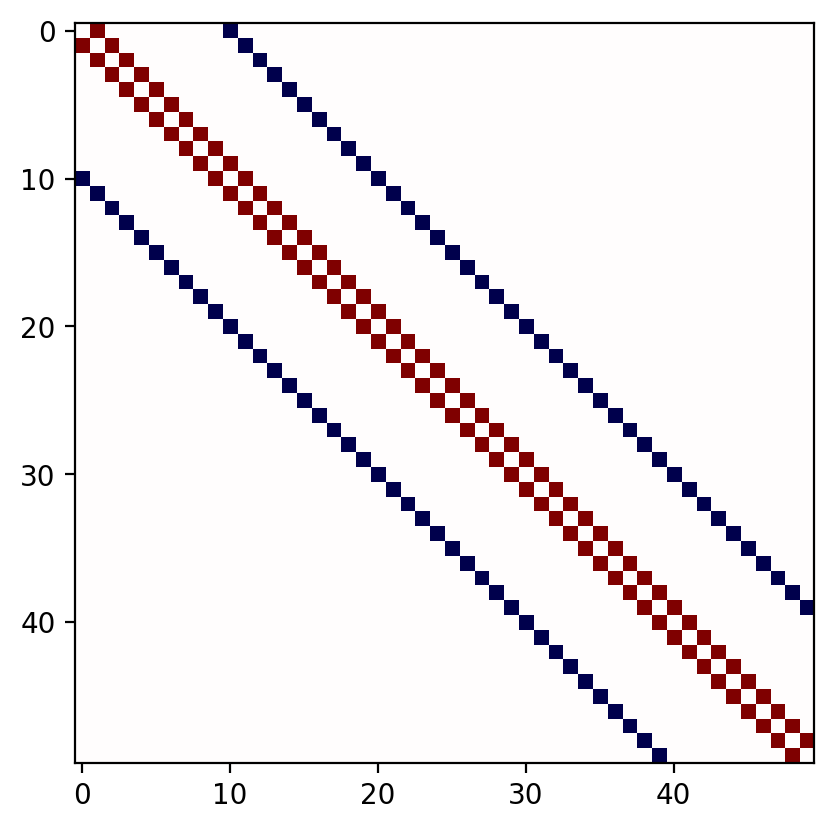

In [4]:
n, d = 400, 3
loop = 10
a = 1e-1

# init_sigma = 3.0 # initial standard deviation of the coordinates
# an initial std of 
init_sigma = n**(1/3)/2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = cg.utils.line_graph_A(n, k=1).to(device)
vdw = cg.utils.line_graph_A(n, k=loop).to(device)

A_loop = A+a*vdw

x = init_sigma*torch.randn(n, d).to(device) 

plt.imshow(V(A-vdw)[:50,:50], cmap='seismic', vmin=-1, vmax=1)

In [5]:
energy_params = dict(radius = 1, thres_A = 1e-4, lj_pow = 6, repel_pow = 1, repel_mag = 2.5e-3, 
                device = 'cuda')

energy_lj = Energy([A_loop], [LJ_potential],log_name='Energy_LJ_2scale', **energy_params)
energy_bond_lj = Energy([A, .1*vdw], [quadratic_potential, LJ_potential],log_name='Energy_Bond_LJ', **energy_params)

In [6]:
energy_bond_lj(x), energy_lj(x)

(tensor(63.1315, device='cuda:0'), tensor(-0.0005, device='cuda:0'))

## Training

In [7]:
PATIENCE = 20
MIN_DELTA = 1e-6
LR = 2e-2

In [8]:
# To collect and plot results, use a list of dictionaries
import datetime

import pandas as pd
import seaborn as sns

class ExperimentLogger:
    def __init__(self, save_prefix = '../results/CG_experiment_', previous_results_csv = None):
        self.results = []
        self.save_prefix = save_prefix
        self.current_experiment = None
        # load previous results as a pd dataframe, if path is given
        # assume the path is a csv file
        if previous_results_csv is not None:
            self.results = pd.read_csv(previous_results_csv).to_dict('records')

    def start_experiment(self, energy_function, # num_nodes, 
                        model_name):
        self.current_experiment = {
            'energy_function': energy_function,
            # 'num_nodes': num_nodes,
            'model_name': model_name,
            'energy': None,
            'time': None
        }
        

    def log_result(self, energy, time, **kws):
        if self.current_experiment is not None:
            self.current_experiment['energy'] = energy
            self.current_experiment['time'] = time
            # allow for additional keyword arguments to be logged
            self.current_experiment.update(kws)

    def end_experiment(self):
        if self.current_experiment is not None:
            self.results.append(self.current_experiment)
            self.current_experiment = None
    
    
    def run_experiment(self, model, epochs=10, steps=5000, log_name=None, **extra_log_kws):
        self._run_stage(model, epochs, steps, log_name)
        # log the result
        self._log_stage(model, **extra_log_kws)
        # end the experiment
        self.end_experiment()
        # save csv after each experiment
        self.to_csv() 
        
    def run_experiment_cg(self, model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
        self._run_stage(model, epochs, steps, log_name)
        # log the result
        self._log_stage_cg(model, cg_mode_time, **extra_log_kws)
        # end the experiment
        self.end_experiment()
        # save csv after each experiment
        self.to_csv()
        
    def run_experiment_gnn(self, model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
        self._run_stage(model, epochs, steps, log_name)
        # log the result
        self._log_stage_gnn(model, cg_mode_time, **extra_log_kws)
        # end the experiment
        self.end_experiment()
        # save csv after each experiment
        self.to_csv()
                
    def _run_stage(self, model, epochs=10, steps=5000, log_name=None):
        log_name = log_name or model.log_name
        # start the experiment
        self.start_experiment(model.energy_func.log_name, log_name)
        print(f'Running experiment {log_name}')
        for i in range(epochs):
            # train the model
            # em.early_stopping_triggered = False
            model.energy_func.update_neg_pairs()
            h = model.train(steps)
            print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
            # log interim result
            self.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
            if model.early_stopping_triggered:
                break
            
    def _log_stage(self, model, **extra_log_kws):
        # log the result
        self.log_result(model.history['energy'][-1], np.sum(model.history['time']),
                    # log hyperparameters such as patience and min_delta
                    lr=model.lr, clamp_grads=model.clamp_grads,
                    patience=model.patience, min_delta=model.min_delta, 
                    **extra_log_kws)    
        
    def _log_stage_cg(self, model, cg_mode_time, **extra_log_kws):
        self.log_result(model.history['energy'][-1], np.sum(model.history['time'])+cg_mode_time,
                # log hyperparameters such as patience and min_delta
                lr=model.lr, lr_cg=model.lr_cg, clamp_grads=model.clamp_grads,
                patience=model.fg_patience, min_delta=model.fg_min_delta, 
                cg_patience=model.cg_patience, cg_min_delta=model.cg_min_delta,
                cg_steps=model.cg_steps, 
                cg_time=np.sum(model.history['time'][:model.cg_steps])+cg_mode_time, 
                cg_energy=model.history['energy'][model.cg_steps-1],
                **extra_log_kws)
        
    def _log_stage_gnn(self, model, cg_mode_time, **extra_log_kws):
        self.log_result(model.history['energy'][-1], np.sum(model.history['time'])+cg_mode_time,
                # log hyperparameters such as patience and min_delta
                num_cg_modes=model.gnn.num_cg,
                lr=model.lr, lr_cg=model.lr_gnn, clamp_grads=model.clamp_grads,
                patience=model.fg_patience, min_delta=model.fg_min_delta, 
                cg_patience=model.gnn_patience, cg_min_delta=model.gnn_min_delta,
                cg_steps=model.gnn_steps, 
                cg_time=np.sum(model.history['time'][:model.gnn_steps])+cg_mode_time, 
                cg_energy=model.history['energy'][model.gnn_steps-1],
                hidden_dims=model.gnn.hidden_dims,
                **extra_log_kws)
            
    def to_dataframe(self):
        return pd.DataFrame(self.results)
    
    def to_csv(self):
        self.df = self.to_dataframe()
        self.df.to_csv(self.save_prefix + datetime.datetime.now().strftime("%Y-%m-%d-%H") + '.csv', index=False)
        
    def plot_results(self, x='time', y='energy', hue='model_name', style='energy_function'):
        # plot as scatter plot
        sns.relplot(data = self.df, x=x, y=y, hue=hue, style=style, kind='scatter')
        # sns.relplot(data = self.df, x=x, y=y, hue=hue, style=style, kind='line')
        
    # when object itself is printed, print the dataframe
    def __repr__(self):
        # only make the dataframe if it doesn't exist
        if not hasattr(self, 'df'):
            self.df = self.to_dataframe()
        # We wnat ensure that the dataframe displayed in the fancy format in the notebook
        # so we use the _repr_html_ method
        return self.df._repr_html_()
        # return self.df
        
    
    
# exp_logger = ExperimentLogger()#'../results/CG_experiment_2024-02-08-18.csv')
exp_logger = ExperimentLogger(save_prefix='../results/LJ_experiment') #(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
test_logger = ExperimentLogger(save_prefix='../results/test')

In [26]:

#############


def run_experiment(model, epochs=10, steps=5000, log_name=None, **extra_log_kws):
    log_name = log_name or model.log_name
    # start the experiment
    exp_logger.start_experiment(model.energy_func.log_name, log_name)
    print(f'Running experiment {log_name}')
    for i in range(epochs):
        # train the model
        # em.early_stopping_triggered = False
        model.energy_func.update_neg_pairs()
        h = model.train(steps)
        print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
        # log interim result
        exp_logger.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
        if model.early_stopping_triggered:
            break
    # log the result
    exp_logger.log_result(model.history['energy'][-1], np.sum(model.history['time']),
                # log hyperparameters such as patience and min_delta
                lr=model.lr, clamp_grads=model.clamp_grads,
                patience=model.patience, min_delta=model.min_delta, 
                **extra_log_kws)    
    # end the experiment
    exp_logger.end_experiment() 
    # save csv after each experiment
    exp_logger.to_csv()  
    

def run_cg_experiment(model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
    log_name = log_name or model.log_name
    # start the experiment
    exp_logger.start_experiment(model.energy_func.log_name, log_name)
    print(f'Running experiment {log_name}')
    for i in range(epochs):
        # train the model
        # em.early_stopping_triggered = False
        model.energy_func.update_neg_pairs()
        h = model.train(steps)
        print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
        # log interim result
        exp_logger.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
        if model.early_stopping_triggered:
            break
    exp_logger.log_result(model.history['energy'][-1], np.sum(model.history['time'])+cg_mode_time,
                # log hyperparameters such as patience and min_delta
                lr=model.lr, lr_cg=model.lr_cg, clamp_grads=model.clamp_grads,
                patience=model.fg_patience, min_delta=model.fg_min_delta, 
                cg_patience=model.cg_patience, cg_min_delta=model.cg_min_delta,
                cg_steps=model.cg_steps, 
                cg_time=np.sum(model.history['time'][:model.cg_steps])+cg_mode_time, 
                cg_energy=model.history['energy'][model.cg_steps-1],
                **extra_log_kws)
    # end the experiment
    exp_logger.end_experiment()   
    # save csv after each experiment
    exp_logger.to_csv()
    
    
# def run_cg_experiment(model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
#     run_experiment(model, epochs, steps, log_name, 
#                 lr_cg=model.lr_cg,
#                 cg_patience=model.cg_patience, cg_min_delta=model.cg_min_delta,
#                 cg_steps=model.cg_steps, 
#                 cg_time=np.sum(model.history['time'][:model.cg_steps])+cg_mode_time, 
#                 cg_energy=model.history['energy'][model.cg_steps-1],
#                 **extra_log_kws)
#     # since we are running cg, we want to also add the cg_time to the experiment time
#     # correct the 'time' stored in exp_logger.results[-1]['time'] by adding cg_mode_time to it
#     exp_logger.results[-1]['time'] += cg_mode_time
#     # save csv after each experiment
#     exp_logger.to_csv()

## Bonds + LJ
quadratic potential along bonds and LJ for weak interactions. 

In [12]:
# define the initial position
initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) / 2

In [16]:
from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch

In [38]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) / 2
# instantiate the EnergyMinimizerPytorch class
em = EnergyMinimizerPytorch(energy_bond_lj, initial_pos, optimizer_type='Adam', lr=1.5*LR, clamp_grads=1., log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='Bond_LJ', patience=PATIENCE, min_delta=MIN_DELTA*1e0)

Using Adam optimizer
Log name: Energy_Bond_LJ2
Logging to: ../results/logs/Energy_Bond_LJ2_n400_d3


In [39]:
exp_logger.run_experiment(em, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment Energy_Bond_LJ2_n400_d3
250 -0.0217, 4.82
500 -0.0239, 9.46
750 -0.0245, 14.08
Early stopping at step 320
767 -0.0244, 14.37


Text(0.5, 1.0, 'Energy vs time (min E: -0.0245, t=14.37 s)')

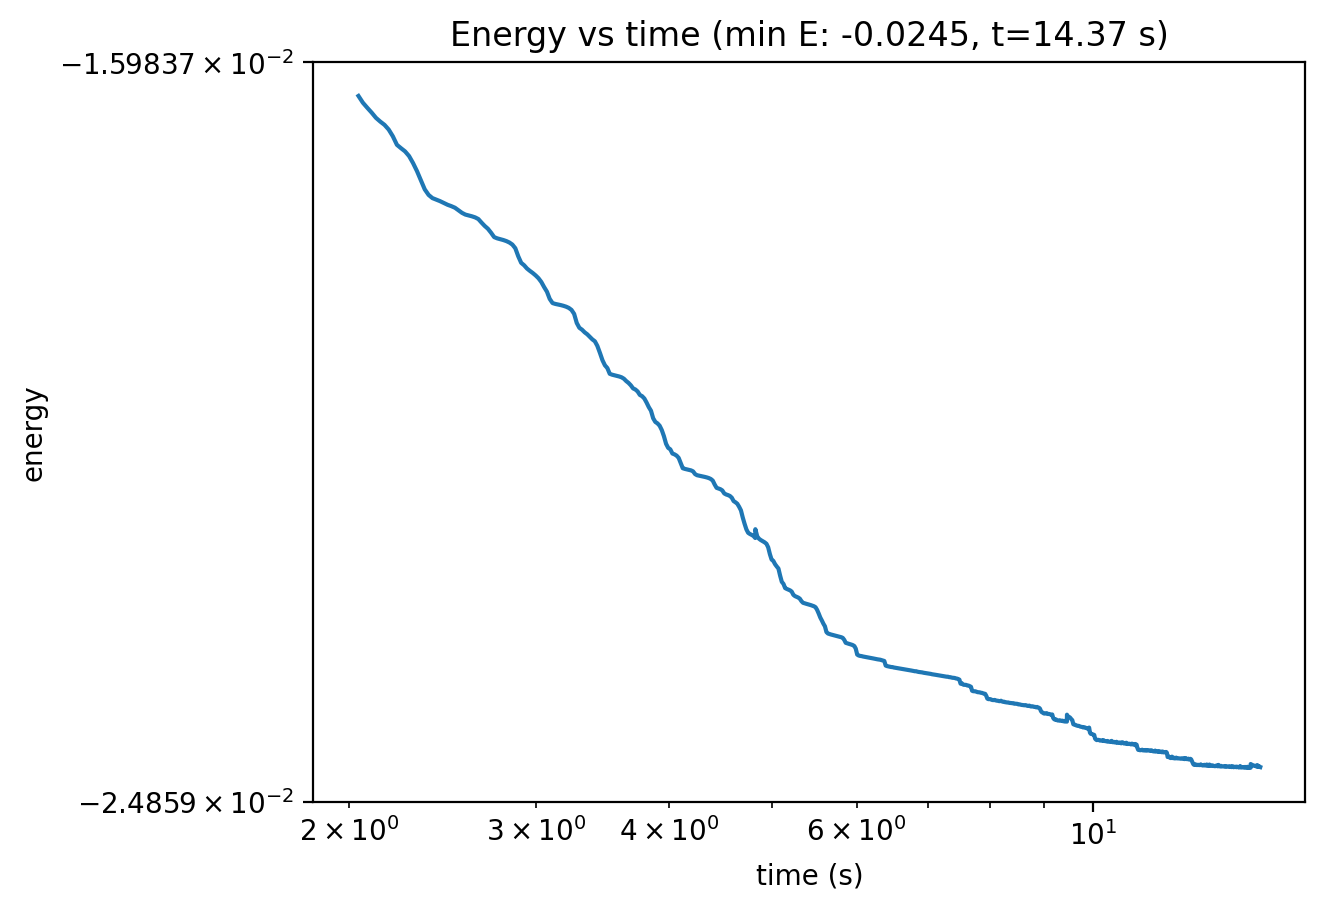

In [40]:
em.plot_history(start=100)
h = em.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [41]:
r = 5e-1
# v = plot_graph_3D(V(em.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(em.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### CG Using multiple samples

In [18]:
# energy_bond_lj.num_neg_pairs = n**2//2
# energy_bond_lj.get_indices()
energy_bond_lj.indices_neg[0].shape

torch.Size([2396])

In [12]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# x_samples = init_sigma*8*torch.randn(4*n, n, d, device =device)
# even very few samples yield good quality cg_modes in this case
x_samples = init_sigma*5*torch.randn(4, n, d, device =device)
cg_lj_sparse = cg.CG.CoarseGrainer(energy_bond_lj, num_cg_modes=120)
cg_lj_sparse.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.12 seconds
spectrum of the Laplacian computed in 0.03 seconds


0.1786353588104248

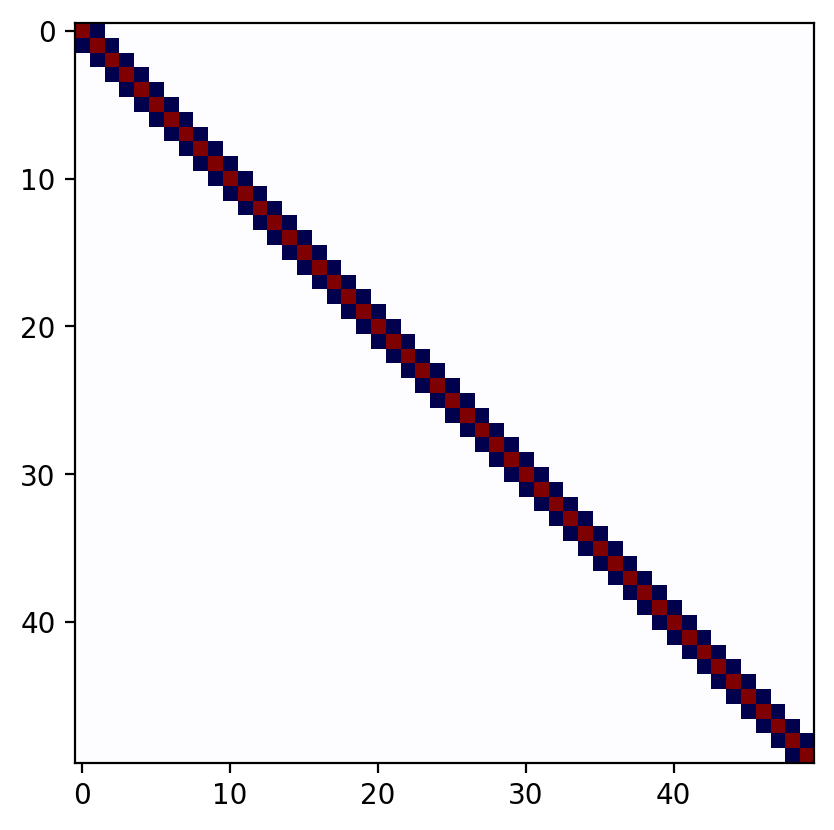

In [13]:
plt.imshow(np.arcsinh(1e4*V(cg_lj_sparse.L))[:50,:50], cmap='seismic', vmin=-1, vmax=1)


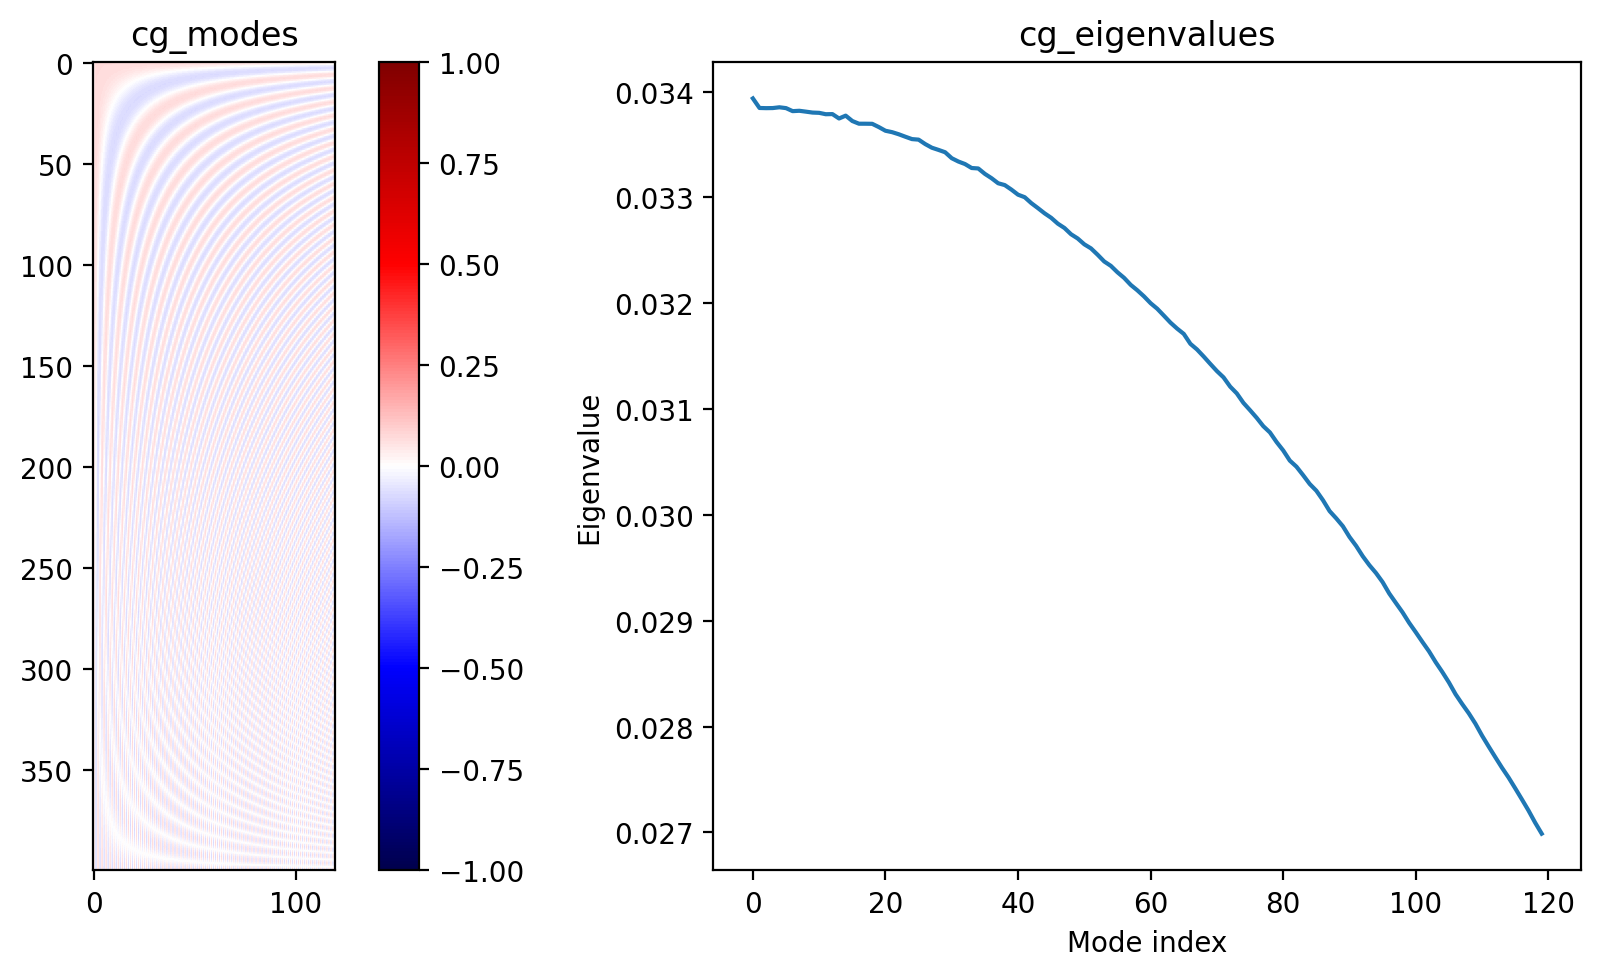

In [14]:
c = V(cg_lj_sparse.cg_modes)
plt.figure(figsize=(10, 5))

# Plot cg_modes
plt.subplot(1, 2, 1)
plt.imshow(c / np.sign(c[[0]]), cmap='seismic', vmin=-1, vmax=1)
plt.title('cg_modes')
plt.colorbar()

# Plot cg_eigenvalues
plt.subplot(1, 2, 2)
plt.plot(V(cg_lj_sparse.cg_eigenvalues))
plt.title('cg_eigenvalues')
plt.xlabel('Mode index')
plt.ylabel('Eigenvalue')

plt.tight_layout()
plt.show()

# c = V(cg_lj_sparse.cg_modes)
# plt.imshow(c/np.sign(c[[0]]), cmap='seismic', vmin=-1, vmax=1) 

In [45]:
# num_cg_modes = n//3
num_cg_modes = n//4

# initial_pos = x = init_sigma*torch.randn(n, d).to(device) /2
# instantiate the CGMinimizerPytorch class
cg_em = CGMinimizerPytorch(energy_bond_lj, initial_pos, cg_lj_sparse.cg_modes[:,:num_cg_modes], 
            optimizer_type='Adam', lr=2*LR, 
            lr_cg=1e-1, #7e-2,#5e-2,
            clamp_grads=1., log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name=f'CG_Bond_LJ{num_cg_modes/n:.2f}', 
            patience=PATIENCE, min_delta=MIN_DELTA*1e0,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*2e1)


# exp_logger.start_experiment(energy_bond_lj.log_name, n, f'CG({num_cg_modes/n:.2f})')

Using Adam optimizer
Log name: Energy_Bond_LJ_CG0.25
Logging to: ../results/logs/Energy_Bond_LJ_CG0.25_n400_d3
Using Adam optimizer


In [46]:
cg_em.energy_func(x).item(), cg_em.energy_func(cg_em.get_x()).item()

(139.5987548828125, 0.37060126662254333)

In [265]:
# remove the last experiment
# exp_logger.results = exp_logger.results[:-1]
# x.std().item(), cg_em.get_x().std().item(), init_sigma

In [47]:
exp_logger.run_experiment_cg(cg_em,cg_mode_time=cg_time,epochs=10, steps=5000, x0_std=cg_em.get_x().std().item())

Running experiment Energy_Bond_LJ_CG0.25_n400_d3
Early stopping at step 4100
Starting fine-graining
456 -0.0245, 8.98
Early stopping at step 300
472 -0.0245, 9.26


In [48]:
exp_logger.df

energy_function                     model_name    energy       time    lr  \
0  Energy_Bond_LJ        Energy_Bond_LJ2_n400_d3 -0.024446  14.371836  0.03   
1  Energy_Bond_LJ  Energy_Bond_LJ_CG0.25_n400_d3 -0.024531   9.307590  0.04   

   clamp_grads  patience  min_delta    x0_std  lr_cg  cg_patience  \
0          1.0        20   0.000001  1.850011    NaN          NaN   
1          1.0        20   0.000001  1.850012    0.1         20.0   

   cg_min_delta  cg_steps   cg_time  cg_energy  
0           NaN       NaN       NaN        NaN  
1       0.00002     206.0  4.392176  -0.023036

(-0.0247, -0.023)

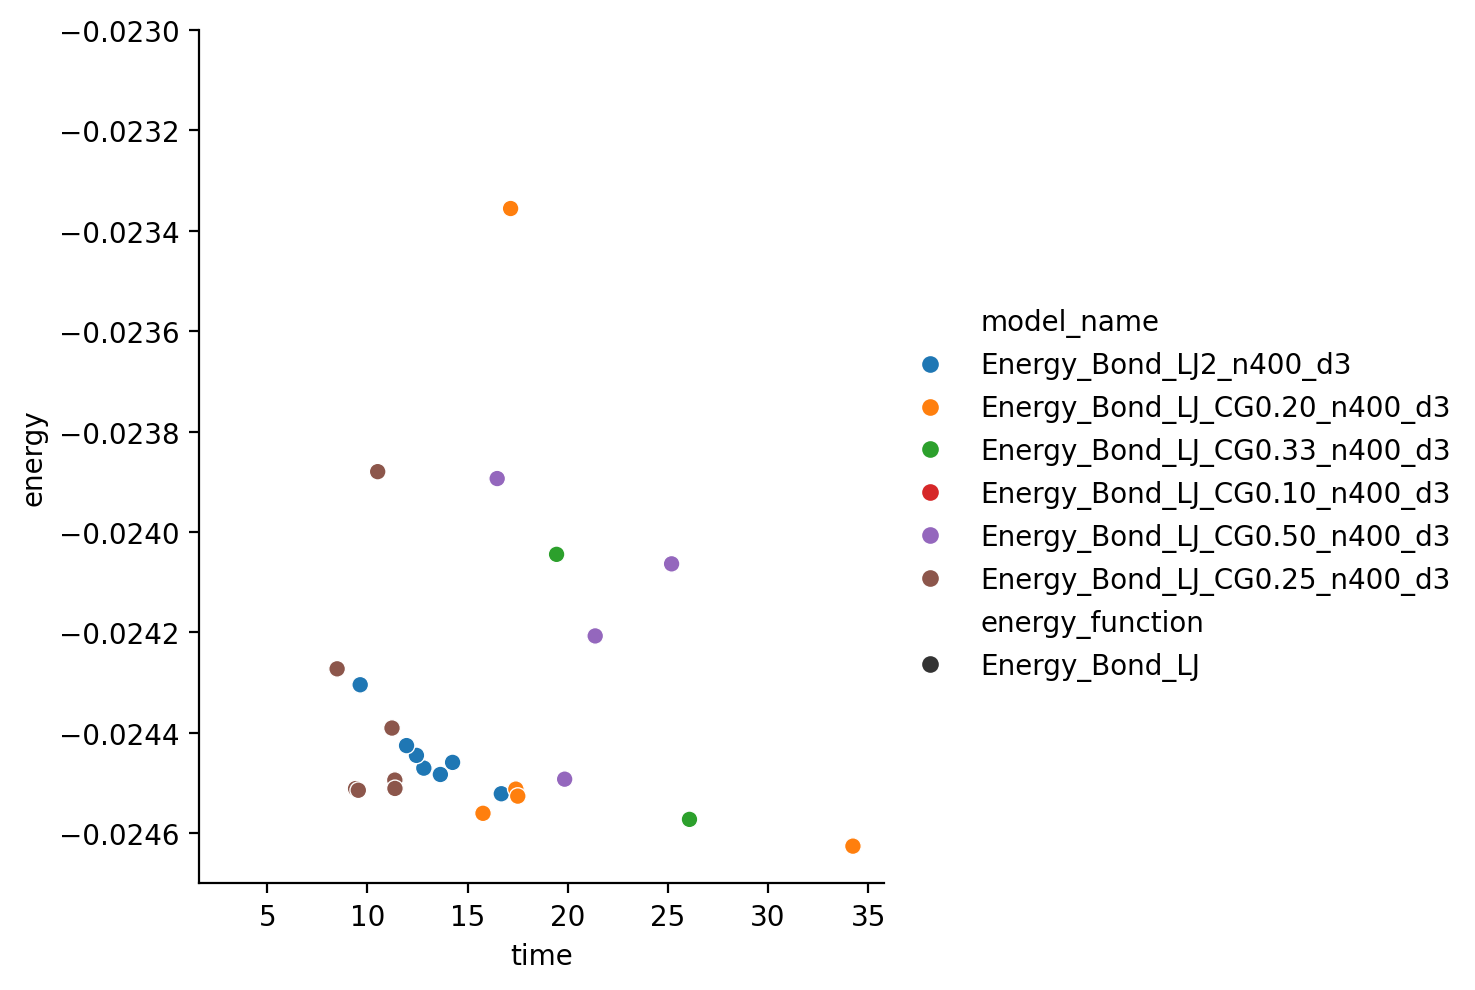

In [17]:
exp_logger.plot_results(x='time', y='energy', hue='model_name', style='energy_function')
plt.ylim(-.0247, -.023)

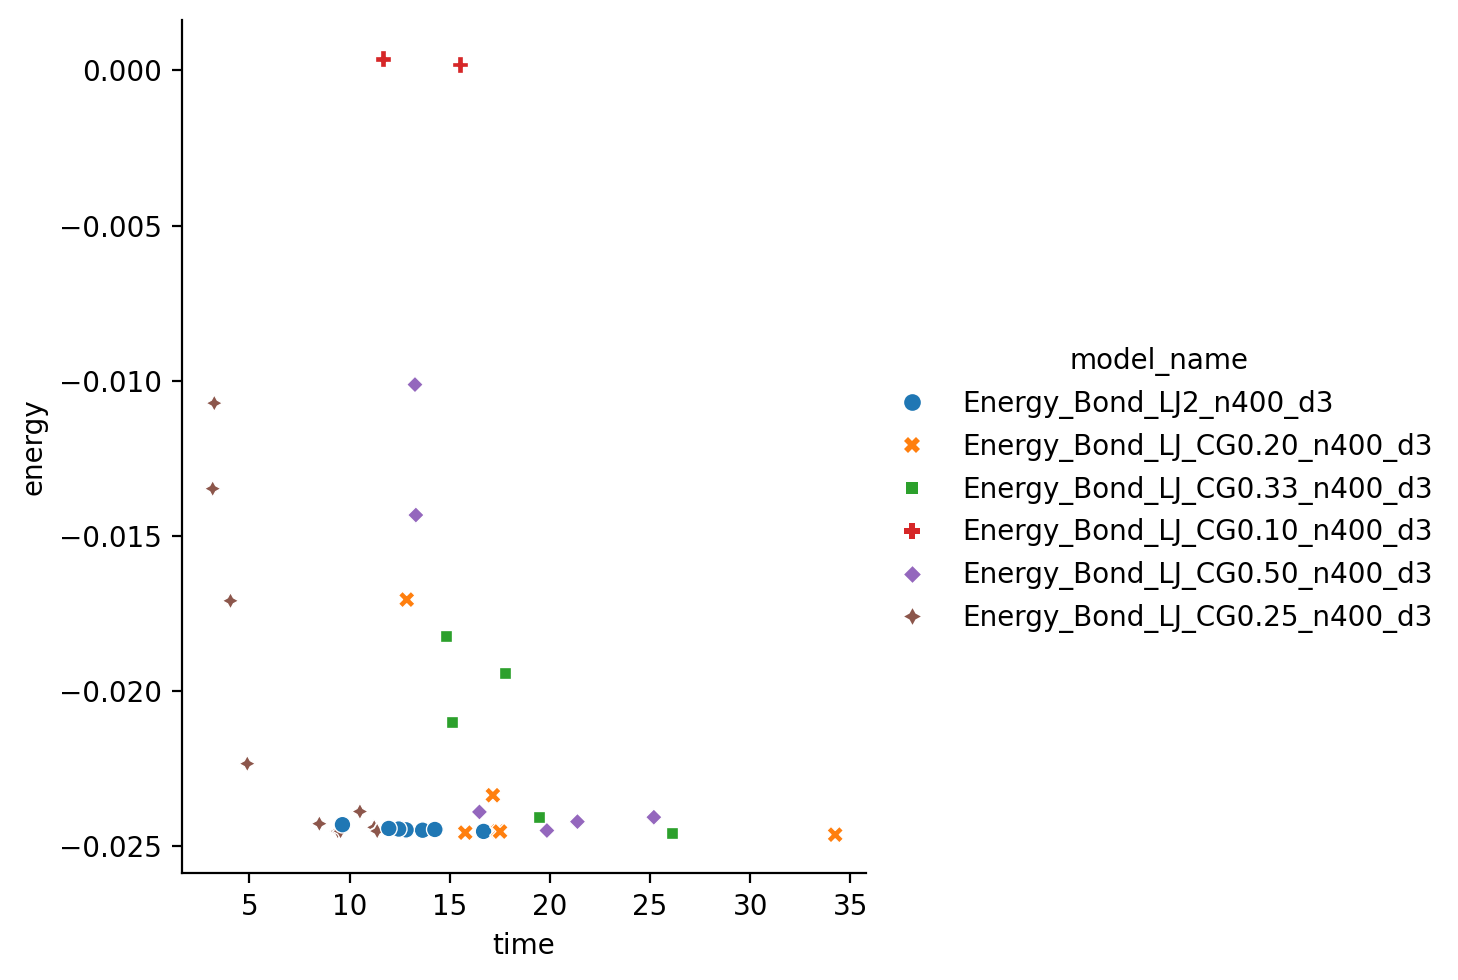

In [18]:
# we also want to plot experiments for a single energy_function
# we can use the pandas groupby method to filter the dataframe
# we can then use the plot_results method to plot the filtered dataframe

# 1. filter the dataframe
# 2. plot the filtered dataframe

# filter the dataframe
df = exp_logger.df
df = df[df['energy_function'] == 'Energy_Bond_LJ']

# plot the filtered dataframe using sns directly on df
sns.relplot(data = df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter')

Text(0.5, 1.0, 'Energy vs time (min E: -0.0245, t=9.26 s)')

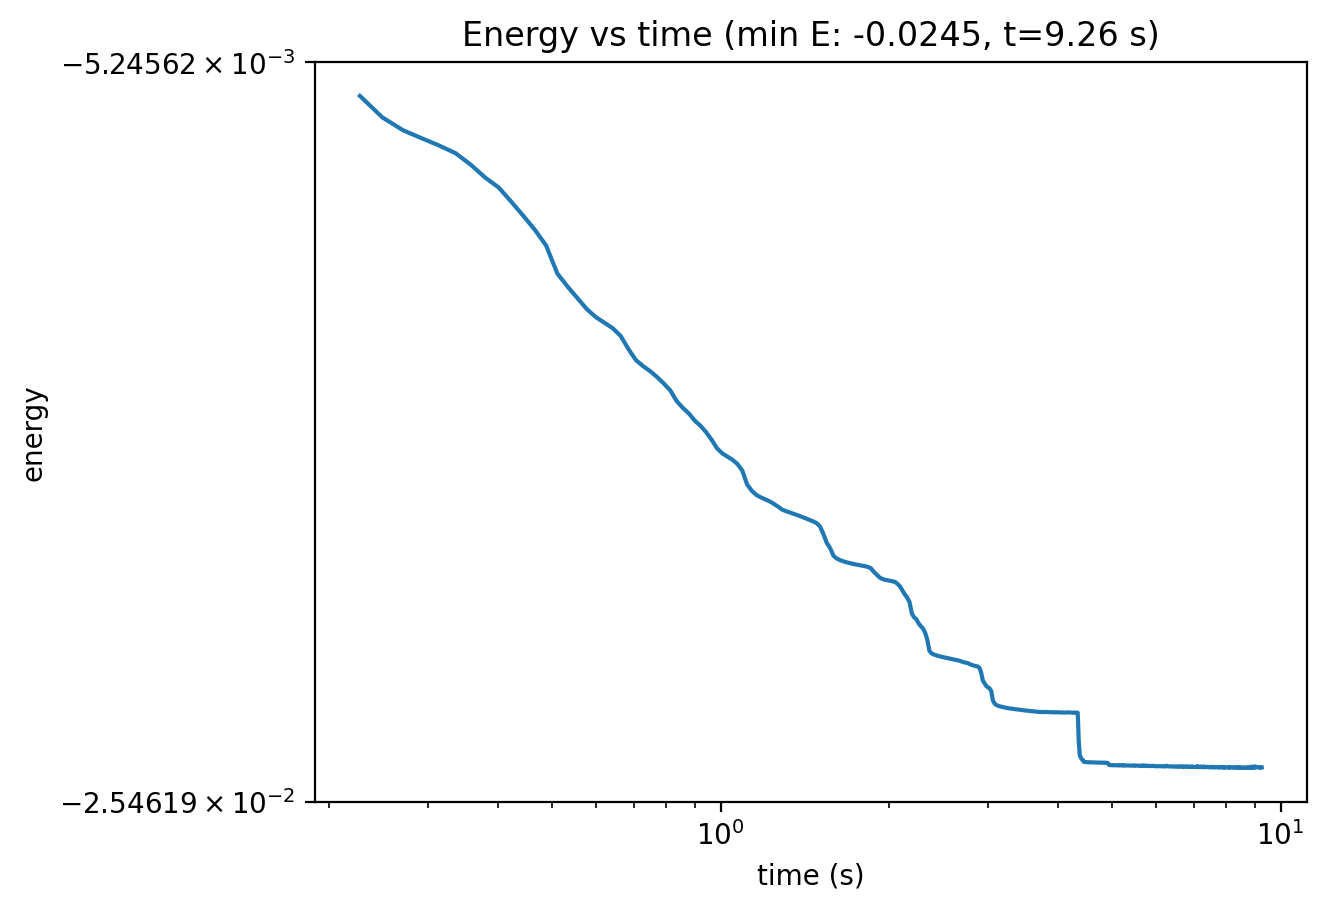

In [49]:
cg_em.plot_history(start=10)
h = cg_em.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
# plt.yscale('linear')


In [50]:
r = 3e-1
# v = plot_graph_3D(V(cg_em.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_em.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### more strict CG
use fewer CG modes and looser early stopping

In [154]:
r = 3e-1
# v = plot_graph_3D(V(cg_em.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_em.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## GNN

In [51]:
# we will implement an efficient graph neural network using pytorch
# this will be used to reparameterize the x variables
# we want to use the cg_modes to define the graph structure
# First, we implement the graph convolutional (GCN) layer
# The GCN layer will use the cg_modes in its forward pass
# so that we never have to explicitly compute the adjacency matrix

class GCN_CG(torch.nn.Module):
    def __init__(self, in_features, out_features, cg, num_cg, bias=True, skip_proj=False, add_self_loops=True):
        """This is a class to implement the graph convolutional layer using PyTorch.
        The graph convolutional layer uses the cg_modes to define the graph structure.

        Args:
            in_features (int): The number of input features.
            out_features (int): The number of output features.
            cg_modes (torch.Tensor): The matrix of cg_modes.
            bias (bool, optional): Whether to include a bias term. Defaults to True.
            skip_proj (bool, optional): Whether to skip the projection to the graph space. Defaults to False.
            add_self_loops (bool, optional): Whether to add self loops to the graph. Defaults to True.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # self.cg = cg  # the cg object
        # to avoid memory leak, we only keep the cg_modes and cg_eigenvalues
        self.num_cg = num_cg
        self.cg_modes = cg.cg_modes[:, :num_cg]
        self.cg_eigenvalues = cg.cg_eigenvalues[:num_cg]
        self.skip_proj = skip_proj
        self.add_self_loops = add_self_loops
        self.get_cg_params()
        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias', None)
        # add parameter for self loops if needed
        if add_self_loops:
            self.self_loops = torch.nn.Parameter(torch.randn(in_features, out_features))
        else:
            self.register_parameter('self_loops', None)
        self.reset_parameters()
        
    def get_cg_params(self,):
        # rescale the cg_modes by the eigenvalues
        self.cg_modes_scaled = self.cg_modes * torch.sqrt(self.cg_eigenvalues)[None, :]
        # also, keep the transpose of the scaled cg_modes for efficient computation
        self.cg_modes_scaled_T = self.cg_modes_scaled.T
        
    def reset_parameters(self):
        # initialize the weights using xavier initialization
        torch.nn.init.xavier_normal_(self.weight)
        if self.bias is not None:
            # initialize the bias to zero
            torch.nn.init.zeros_(self.bias)
        if self.add_self_loops:
            # initialize the self loops to normal 
            torch.nn.init.normal_(self.self_loops)
            
    def forward(self, x):
        # compute the graph convolution
        # assume x is of shape (n, in_features)
        if not self.skip_proj:
            # we project the output features to the graph space
            # here, the graph adjacency matrix is given by A = cg_modes @ cg_modes.T
            # so we can use the cg_modes to define the graph convolution
            # for efficiency, we won't explicitly compute A
            # instead we perform convolution using the cg_modes_scaled in two steps as
            z = self.cg_modes_scaled_T @ x
            # # also use the cg eigenvalues to scale the output
            # z = z * self.cg_eigenvalues[:, None]
            # then, we project the graph space back to the output features
            x1 = self.cg_modes_scaled @ z
            # # add self loops
            # if self.add_self_loops:
            #     x = x1 + x
            # else:
            #     x = x1
        else:
            x1 = x   
        # we project the input features to the output features
        x1 = x1 @ self.weight
        # add self loops
        if self.add_self_loops:
            x1 = x1 + x @ self.self_loops
        # add bias
        if self.bias is not None:
            x1 = x1 + self.bias
        return x1

# Define a resisual block using the GCN layer
# The residual block will use the GCN layer to perform the graph convolution

class ResGCN_CG(torch.nn.Module):
    def __init__(self, in_features, out_features, cg,num_cg, bias=True, activation=torch.nn.ReLU()):
        """This is a class to implement the residual block using the graph convolutional layer.

        Args:
            in_features (int): The number of input features.
            out_features (int): The number of output features.
            cg_modes (torch.Tensor): The matrix of cg_modes.
            bias (bool, optional): Whether to include a bias term. Defaults to True.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_cg = num_cg
        self.gcn1 = GCN_CG(in_features, out_features, cg, num_cg, bias)
        self.gcn2 = GCN_CG(out_features, out_features, cg, num_cg, bias)
        self.act = activation
        # because the input and output dimensions are different, we need to project the input to the output
        self.proj = torch.nn.Linear(in_features, out_features)
        
    def forward(self, x):
        # compute the residual block
        # assume x is of shape (n, in_features)
        # first, we perform the graph convolution using the first GCN layer
        x1 = self.gcn1(x)
        # then, we apply the ReLU activation
        x1 = self.act(x1)
        # then, we perform the graph convolution using the second GCN layer
        x2 = self.gcn2(x1)
        # finally, we add the input to the output
        # note that we cannot add the input to the output if the input 
        # and output dimensions are different
        x = x2 + self.proj(x)
        return x

# Next, we implement the graph neural network (GNN) using the GCN layer
# the GNN will use the GCN layer to perform the graph convolution
# it will take a set of hidden dimensions, including the input and output dimensions


class GNNRes(torch.nn.Module):
    def __init__(self, hidden_dims, cg, num_cg , bias=True, activation=torch.nn.ReLU()):
        """This is a class to implement the graph neural network using the residual GCN block.
        It will also have a final linear layer to project the output to the desired dimension.

        Args:
            hidden_dims (list): The list of hidden dimensions. 
                The first element is the input dimension and 
                the last element is the output dimension. 
                It should have at least two elements.
            cg (object): The object containing the cg_modes and cg_eigenvalues.
            num_cg (int): The number of cg_modes to use.
            bias (bool, optional): Whether to include a bias term. 
                Defaults to True.
            activation (torch.nn.Module, optional): The activation function. 
                Defaults to torch.nn.ReLU().
        """
        super().__init__()
        self.hidden_dims = hidden_dims
        self.num_layers = len(hidden_dims) - 1
        self.num_cg = num_cg
        self.layers = torch.nn.ModuleList()
        for i in range(self.num_layers - 1):
            self.layers.append(ResGCN_CG(hidden_dims[i], hidden_dims[i+1], cg, num_cg, bias, activation))
        # the final layer is a linear layer
        self.layers.append(torch.nn.Linear(hidden_dims[-2], hidden_dims[-1]))
        self.act = activation
        
    def forward(self, x):
        # compute the graph neural network
        # assume x is of shape (n, in_features)
        for i in range(self.num_layers - 1):
            x = self.layers[i](x)
            # apply the activation
            x = self.act(x)
        # apply the final layer
        x = self.layers[-1](x)
        return x        
    
# Next, we implement the graph neural network (GNN) using the GCN layer

class GNN(torch.nn.Module):
    def __init__(self, hidden_dims, cg, num_cg, bias=True, activation=torch.nn.ReLU()):
        """This is a class to implement the graph neural network using the GCN layer.
        It will also have a final linear layer to project the output to the desired dimension.

        Args:
            hidden_dims (list): The list of hidden dimensions. 
                The first element is the input dimension and 
                the last element is the output dimension. 
                It should have at least two elements.
            cg (object): The object containing the cg_modes and cg_eigenvalues.
            num_cg (int): The number of cg_modes to use.
            bias (bool, optional): Whether to include a bias term. 
                Defaults to True.
            activation (torch.nn.Module, optional): The activation function. 
                Defaults to torch.nn.ReLU().
        """
        super().__init__()
        self.hidden_dims = hidden_dims
        self.num_layers = len(hidden_dims) - 1
        self.num_cg = num_cg
        self.layers = torch.nn.ModuleList()
        for i in range(self.num_layers - 1):
            self.layers.append(GCN_CG(hidden_dims[i], hidden_dims[i+1], cg, num_cg, bias))
        # the final layer is a linear layer
        self.layers.append(torch.nn.Linear(hidden_dims[-2], hidden_dims[-1]))
        self.act = activation
        
    def forward(self, x):
        # compute the graph neural network
        # assume x is of shape (n, in_features)
        for i in range(self.num_layers - 1):
            x = self.layers[i](x)
            # apply the activation
            x = self.act(x)
        # apply the final layer
        x = self.layers[-1](x)
        return x

# GNN reparemeterization:
# we will use the GNN to reparameterize the x variables
# we introduce a convenience class to perform the reparameterization
# this class includes both the GNN and the initial position as parameters
# it will take the same inputs as the GNN class and return the reparameterized x

class GNNReparam(torch.nn.Module):
    def __init__(self, hidden_dims, cg, num_cg, latent_sigma, bias=True, activation=torch.nn.ReLU(), GNN_class=GNN):
        """This is a class to implement the graph neural network reparameterization.
        

        Args:
            hidden_dims (list): The list of hidden dimensions. 
                The first element is the input dimension and 
                the last element is the output dimension. 
                It should have at least two elements.
            cg (object): The object containing the cg_modes and cg_eigenvalues.
            num_cg (int): The number of cg_modes to use.
            initial_pos (torch.Tensor): The initial position of the particles.
            bias (bool, optional): Whether to include a bias term. 
                Defaults to True.
            activation (torch.nn.Module, optional): The activation function. 
                Defaults to torch.nn.ReLU().
        """
        super().__init__()
        self.hidden_dims = hidden_dims
        self.num_cg = num_cg
        self.gnn = GNN_class(hidden_dims, cg, num_cg, bias, activation)
        self.n = cg.cg_modes.shape[0]
        self.get_latent_embedding(latent_sigma)
        
    def get_latent_embedding(self, latent_sigma):
        # get the latent embedding
        # we use the latent_sigma to scale the initial position
        self.latent_embedding = torch.nn.Parameter(latent_sigma * torch.randn(self.n, self.gnn.hidden_dims[0]))
                
    def forward(self):
        # compute the reparameterized x
        # assume x is of shape (n, in_features)
        return self.gnn(self.latent_embedding)

In [109]:

# we will use the GNNReaparam to reparameterize the x variables
# for the optimization, we will use the same two stage optimization
# in the first stage the optimization variables will be the GNN parameters 
# and in the second stage the optimization variables will be the x variables
# we will use the same EnergyMinimizerPytorch class to perform the optimization
# the only difference is that we will use the GNN to compute the x variables
# and we will use the x variables to compute the energy
# The GNN minimizer will also use the GNN parameters as the optimization variables
# make this a subclass of the EnergyMinimizerPytorch1 class
# we will have a method to switch between the two stages
# the switch will be triggered by the early stopping mechanism
# when switching, we will change the optimizer to the fine grained optimizer
# we will also reset the early stopping mechanism
# the get_x method will return the GNN reparameterized x when coarse grained 
# and the original x when fine grained

class GNNMinimizerPytorch(EnergyMinimizerPytorch):
    def __init__(self, energy_func, initial_pos, gnn_reparam, optimizer_type=None, lr=0.1, lr_gnn=0.1, clamp_grads=1., 
                log_step=10, log_pos_step=0, log_dir='../results/logs', 
                patience=5, min_delta=0.0, gnn_patience=5, gnn_min_delta=0.0, log_name=None):
        super().__init__(energy_func, initial_pos, optimizer_type, lr, clamp_grads, 
                log_step, log_pos_step, log_dir, patience, min_delta, log_name)
        self.gnn = gnn_reparam
        self.lr_gnn = lr_gnn
        self.optimizer_gnn = self.get_optimizer(self.gnn.parameters(), lr=self.lr_gnn)
        self.fg_optimizer = self.optimizer
        self.optimizer = self.optimizer_gnn
        self.init_GNN_hyperparameters(gnn_patience, gnn_min_delta, patience, min_delta)
        self.fine_grained = False
        # add the gnn_patience and gnn_min_delta to the hyperparameters
        self.writer.add_hparams({'gnn_hidden_dims': torch.tensor(self.gnn.hidden_dims),
            'lr': self.lr, 'lr_gnn': self.lr_gnn, 'clamp_grads': self.clamp_grads, 'log_step': self._log_step,
            'log_pos_step': self._log_pos_step, 'patience': self.fg_patience, 'min_delta': self.fg_min_delta,
            'gnn_patience': gnn_patience, 'gnn_min_delta': gnn_min_delta}, {})
        
    def init_GNN_hyperparameters(self, gnn_patience, gnn_min_delta, fg_patience, fg_min_delta):
        self.gnn_patience = gnn_patience
        self.gnn_min_delta = gnn_min_delta
        # during gnn, self.patience and self.min_delta should be the gnn patience and min_delta
        # later during fg, we will reset them to the original values
        # first, keep the originals as fg_patience and fg_min_delta
        self.fg_patience = fg_patience
        self.fg_min_delta = fg_min_delta
        # we are starting with gnn, so set the patience and min_delta to the gnn values
        self.patience = gnn_patience
        self.min_delta = gnn_min_delta
        
    def get_x(self):
        # get the position variables
        # in the GNN stage, x = gnn(latent_embedding)
        # in the fine-grained stage, x = x
        if self.fine_grained:
            return self.x
        else:
            return self.gnn()
        
    # toggle fine_grained to switch between the two stages
    # when turning fine_grained to True, we need to update the value of x
    # and reset the state of the fine-grained optimizer
    def start_fine_graining(self):
        self.x.data = self.get_x().data
        # now that the GNN stage has finished, log current `x_gnn = self.get_x()` in history as "x_gnn"
        self.history['x_gnn'] = self.x.detach().cpu().clone().numpy()
        
        # reset the state of the fine-grained optimizer
        self.optimizer = getattr(torch.optim, self.optimizer_type)([self.x], lr = self.lr)
        self.fg_optimizer = self.optimizer
        self.gnn_steps = len(self.history['time'])
        # change the patience and min_delta to the fine-grained values
        self.patience = self.fg_patience
        self.min_delta = self.fg_min_delta
        # unset the early stopping flag
        self.early_stopping_triggered = False
        self.fine_grained = True
        # we are starting the fine-grained stage, so reset the patience counter
        self.patience_counter = 0
        
    # We also want a full training loop that can switch between the two stages
    # we will use the same training loop as before
    # the only difference is that we will switch between the two stages
    # we will use the early stopping mechanism to switch between the two stages
    def train_full(self, nsteps):
        # first, we will train the CG stage
        # since both stages use the same training loop, we can use the same method
        h = self.train(nsteps)
        # now check if early stopping was triggered
        # then, if we were not already in the fine-grained stage, we switch to the fine-grained stage
        if self.early_stopping_triggered and not self.fine_grained:
            self.start_fine_graining()
            # now we train the fine-grained stage
            h = self.train(nsteps)
            
        return h
        

In [10]:
from coarsegrainer.GNN import GCN_CG, ResGCN_CG, GNNRes, GNN, GNNReparam

In [15]:
# example of using the GCN_CG class
h = 10

num_cg_modes = n//4
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, h).to(device)

# instantiate the GCN_CG class
gcn = GCN_CG(h, d, cg_lj_sparse, num_cg=num_cg_modes, bias=True).to(device)

# instantiate the ResGCN_CG class
resgcn = ResGCN_CG(h, d, cg_lj_sparse, num_cg=num_cg_modes, bias=True).to(device)

# instantiate the GNN class
gnn = GNN([h, h//2, d], cg_lj_sparse, num_cg=num_cg_modes, bias=True).to(device)

# parameters count for the GCN_CG class
[(torch.norm(p).item(),p.shape) for p in gcn.parameters()]

[(1.9676259756088257, torch.Size([10, 3])),
 (0.0, torch.Size([3])),
 (4.555346965789795, torch.Size([10, 3]))]

In [53]:
gnn_reparam = GNNReparam([h, h//2, d], cg_lj_sparse, num_cg=num_cg_modes, latent_sigma=init_sigma, bias=True).to(device)

In [54]:
# get the cg_modes from gnn_reparam
gnn_reparam.gnn.layers[0].cg_modes_scaled.shape

torch.Size([400, 100])

In [55]:
gnn

GNN(
  (layers): ModuleList(
    (0): GCN_CG()
    (1): Linear(in_features=5, out_features=3, bias=True)
  )
  (act): ReLU()
)

In [124]:

def run_gnn_experiment(model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
    log_name = log_name or model.log_name
    # start the experiment
    exp_logger.start_experiment(model.energy_func.log_name, log_name)
    print(f'Running experiment {log_name}')
    for i in range(epochs):
        # train the model
        # em.early_stopping_triggered = False
        model.energy_func.update_neg_pairs()
        h = model.train_full(steps)
        print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
        # log interim result
        exp_logger.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
        if model.early_stopping_triggered:
            break
    exp_logger.log_result(model.history['energy'][-1], np.sum(model.history['time'])+cg_mode_time,
                # log hyperparameters such as patience and min_delta
                num_cg_modes=model.gnn.num_cg,
                lr=model.lr, lr_cg=model.lr_gnn, clamp_grads=model.clamp_grads,
                patience=model.fg_patience, min_delta=model.fg_min_delta, 
                cg_patience=model.gnn_patience, cg_min_delta=model.gnn_min_delta,
                cg_steps=model.gnn_steps, 
                cg_time=np.sum(model.history['time'][:model.gnn_steps])+cg_mode_time, 
                cg_energy=model.history['energy'][model.gnn_steps-1],
                hidden_dims=model.gnn.hidden_dims,
                **extra_log_kws)
    # end the experiment
    exp_logger.end_experiment()   
    # save csv after each experiment
    exp_logger.to_csv()

In [25]:
# example of using the GNNMinimizerPytorch class
# define the initial position
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4
print(f"Initial std of x: {x.std().item():.3g}")

# example of using the GNNReparam class
h=10
num_cg_modes = n//5

n = len(A)
# similar to xavier initialization, we can set latent_sigma to 1/sqrt(h)
gnn_reparam = GNNReparam([h, h//2, d], cg_lj_sparse, num_cg=num_cg_modes, latent_sigma=1/np.sqrt(h), bias=True, activation=torch.nn.Tanh()).to(device)
print(f"std before rescaling {gnn_reparam().std().item():.3g}")

# since std of x is init_sigma, std of gnn_reparam should be init_sigma
# but because of the gnn, it is not
# we can use the last linear layer to scale the output to match x
# we can use the std of the last layer to scale the output
# we will rescale the parameters of the last layer to match the std of x

init_gnn_std = gnn_reparam().std()
# rescale the weights of the last layer by the ratio of the stds
gnn_reparam.gnn.layers[-1].weight.data *= init_sigma/init_gnn_std*1.
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

# instantiate the GNNMinimizerPytorch class
gnn_em = GNNMinimizerPytorch(energy_bond_lj, initial_pos, gnn_reparam, optimizer_type='Adam', 
                            lr=2*LR, lr_gnn=2e-3,
                            clamp_grads=1e-2, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name=f'GNN_Bond_LJ{num_cg_modes/n:.2f}',
                            patience=PATIENCE, min_delta=MIN_DELTA*1e1, 
                            gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e1)


Initial std of x: 0.893
std before rescaling 0.478
std after rescaling 2.91
Using Adam optimizer
Log name: GNN_Bond_LJ0.20
Logging to: ../results/logs/GNN_Bond_LJ0.20_n400_d3
Using Adam optimizer


In [26]:
gnn_em.energy_func(x), gnn_em.energy_func(gnn_em.get_x())

(tensor(680.2264, device='cuda:0'),
 tensor(43.4323, device='cuda:0', grad_fn=<AddBackward0>))

In [27]:
# exp_logger.run_experiment_gnn(gnn_em,cg_mode_time=cg_time,epochs=10, steps=5000, x0_std=gnn_em.get_x().std().item())
test_logger.run_experiment_gnn(gnn_em,cg_mode_time=cg_time,epochs=10, steps=5000, x0_std=gnn_em.get_x().std().item())

Running experiment GNN_Bond_LJ0.20_n400_d3


250 -0.0216, 6.01
500 -0.0241, 11.91
Early stopping at step 300
Early stopping at step 4520
743 -0.0245, 16.46


In [28]:
test_logger.df

energy_function               model_name    energy       time  num_cg_modes  \
0  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.022962  17.031980            80   
1  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.024336  16.141128            80   
2  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.024466  16.636397            80   

     lr  lr_cg  clamp_grads  patience  min_delta  cg_patience  cg_min_delta  \
0  0.04  0.002         0.01        20    0.00001           20       0.00001   
1  0.04  0.002         0.01        20    0.00001           20       0.00001   
2  0.04  0.002         0.01        20    0.00001           20       0.00001   

   cg_steps    cg_time  cg_energy hidden_dims    x0_std  
0       520  12.619572  -0.022410  [10, 5, 3]  3.240644  
1       514  12.490475  -0.023731  [10, 5, 3]  2.660782  
2       516  12.440299  -0.024125  [10, 5, 3]  2.909130

In [29]:
# exp_logger.results[-7]['model_name']
# exp_logger.results = exp_logger.results[:-2]
# exp_logger.to_dataframe()

Text(0.5, 1.0, 'Energy vs time (min E: -0.0245, t=16.46 s)')

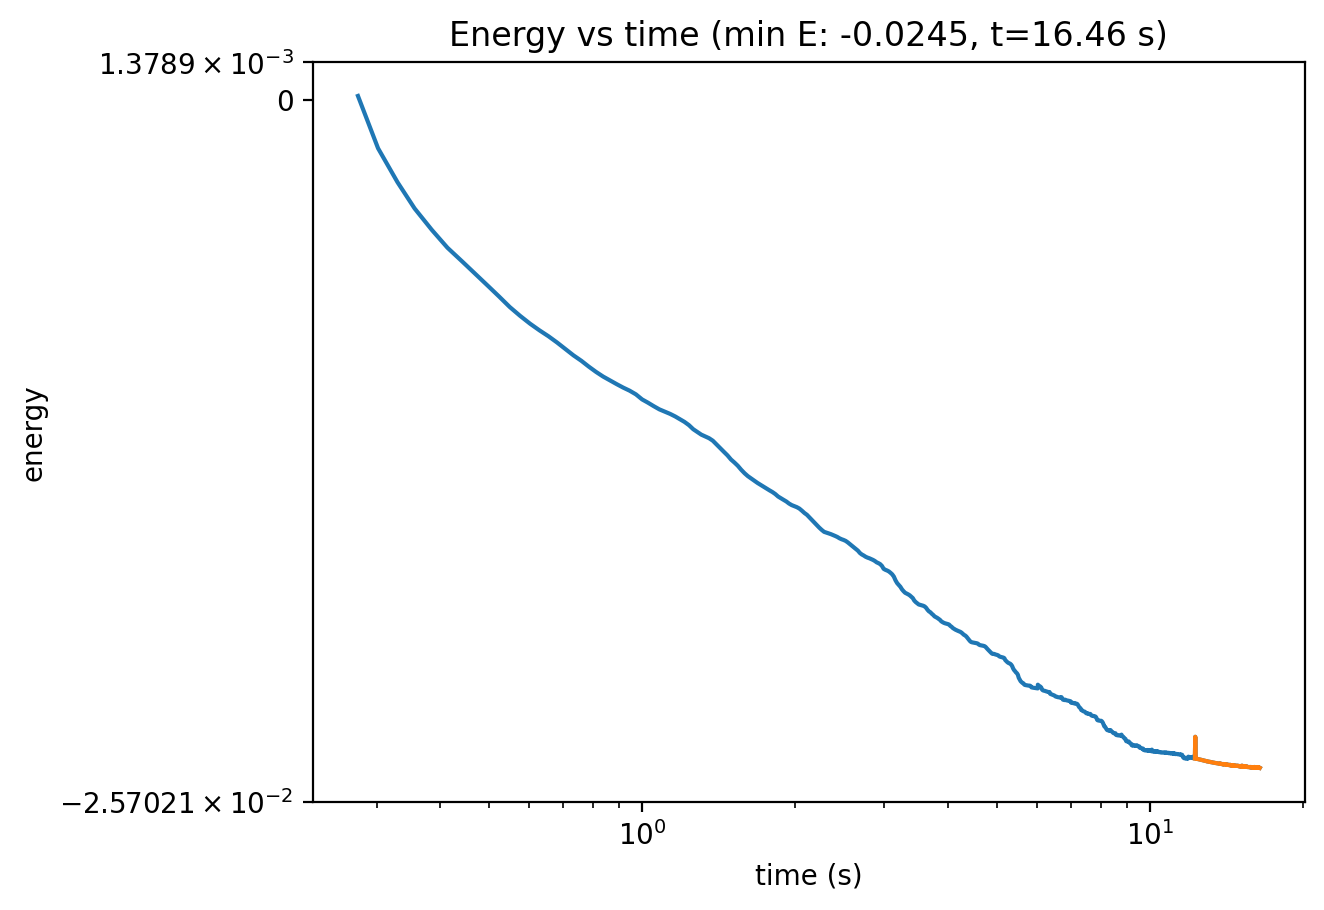

In [30]:
gnn_em.plot_history(start=10)
gnn_em.plot_history(start=gnn_em.gnn_steps)
h = gnn_em.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
# plt.yscale('linear')


In [66]:
exp_logger.df[-10:]

energy_function                     model_name    energy       time    lr  \
0  Energy_Bond_LJ        Energy_Bond_LJ2_n400_d3 -0.024446  14.371836  0.03   
1  Energy_Bond_LJ  Energy_Bond_LJ_CG0.25_n400_d3 -0.024531   9.307590  0.04   
2  Energy_Bond_LJ        GNN_Bond_LJ0.25_n400_d3 -0.024449  15.204830  0.04   
3  Energy_Bond_LJ        GNN_Bond_LJ0.20_n400_d3 -0.024441  16.536901  0.04   

   clamp_grads  patience  min_delta    x0_std  lr_cg  cg_patience  \
0         1.00        20   0.000001  1.850011    NaN          NaN   
1         1.00        20   0.000001  1.850012  0.100         20.0   
2         0.01        20   0.000010  3.439259  0.004         20.0   
3         0.01        20   0.000010  3.202150  0.002         20.0   

   cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes hidden_dims  
0           NaN       NaN        NaN        NaN           NaN         NaN  
1       0.00002     206.0   4.392176  -0.023036           NaN         NaN  
2       0.00001     475.0  11.655489  -0.024160         100.0  [10, 5, 3]  
3       0.00001     516.0  12.541321  -0.023213          80.0  [10, 5, 3]

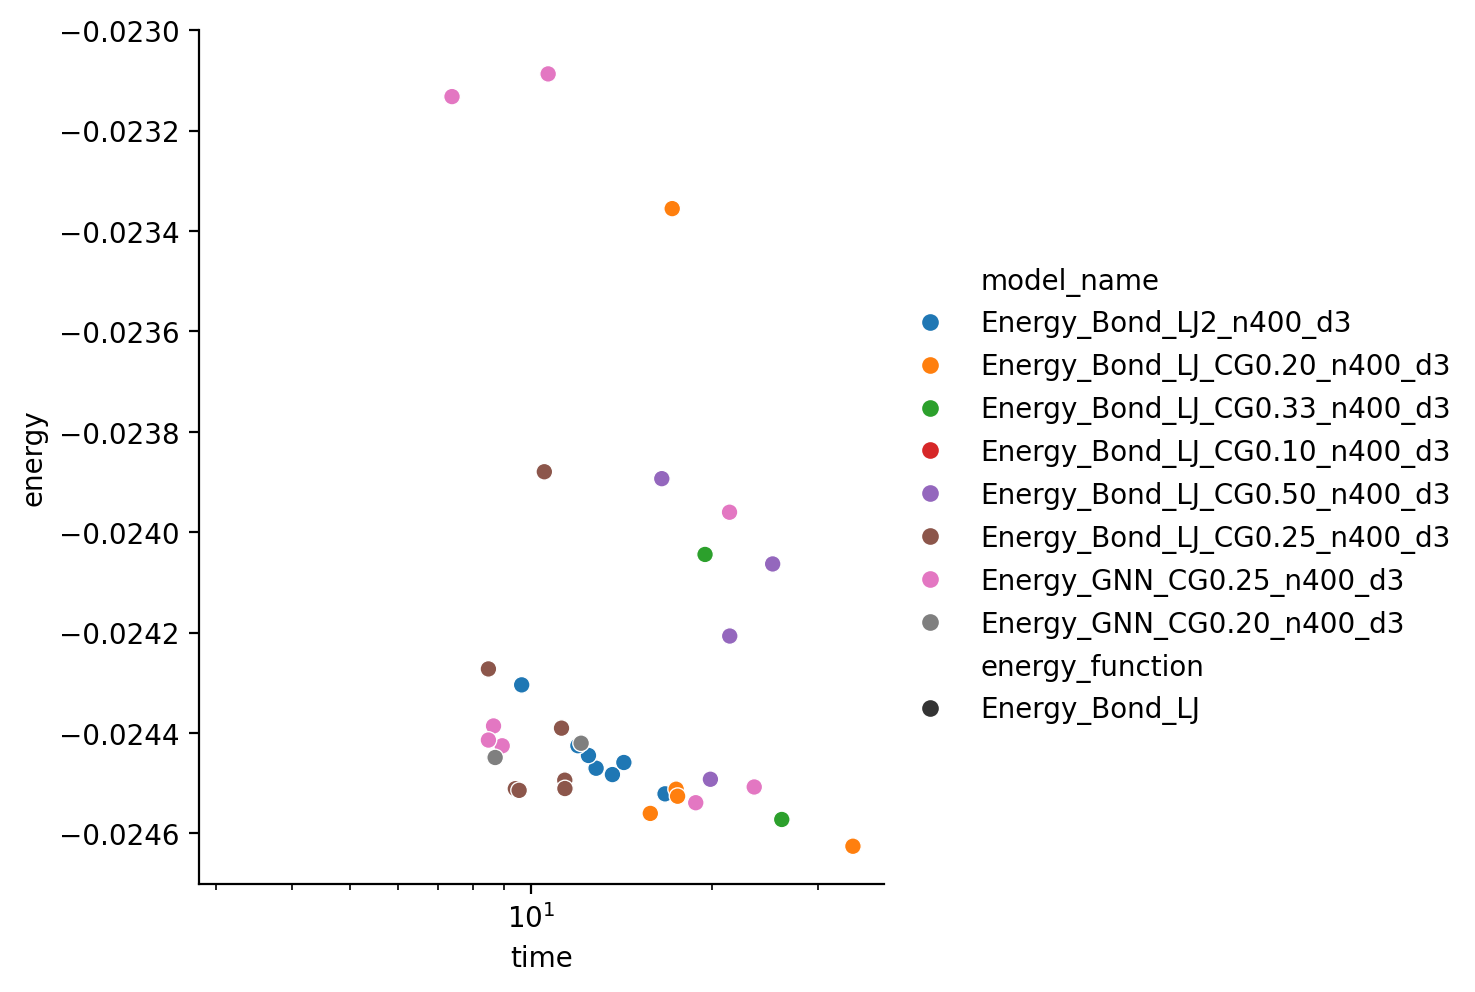

In [212]:
exp_logger.plot_results(x='time', y='energy', hue='model_name', style='energy_function')
plt.ylim(-.0247, -.023)
plt.xscale('log')

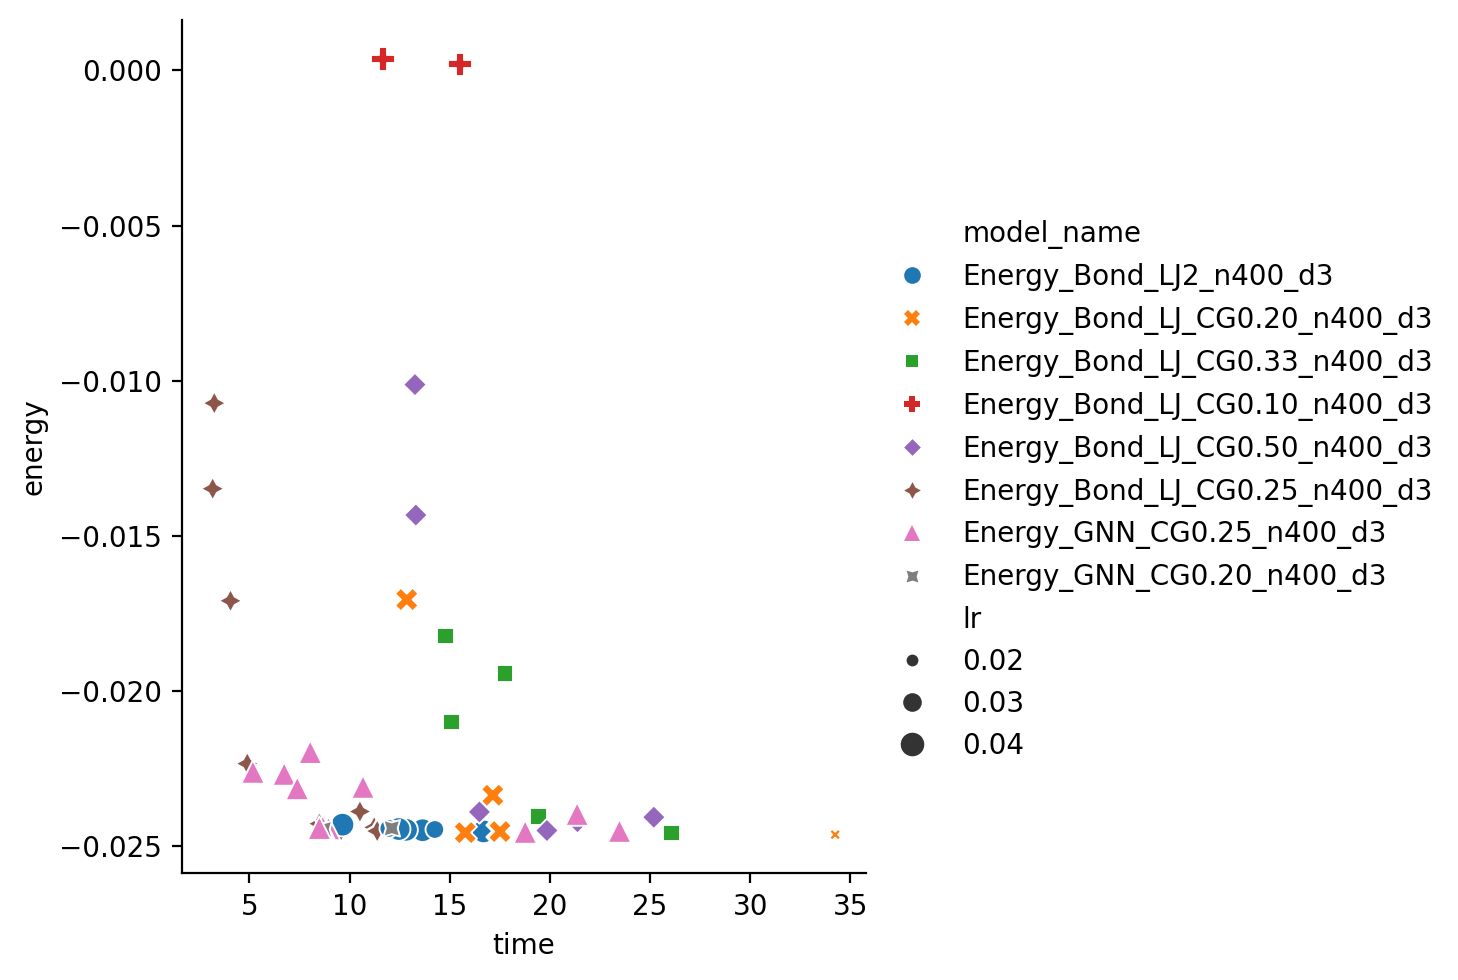

In [215]:
# we also want to plot experiments for a single energy_function
# we can use the pandas groupby method to filter the dataframe
# we can then use the plot_results method to plot the filtered dataframe

# 1. filter the dataframe
# 2. plot the filtered dataframe

# filter the dataframe
df = exp_logger.df
df = df[df['energy_function'] == 'Energy_Bond_LJ']

# plot the filtered dataframe using sns directly on df
sns.relplot(data = df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr')


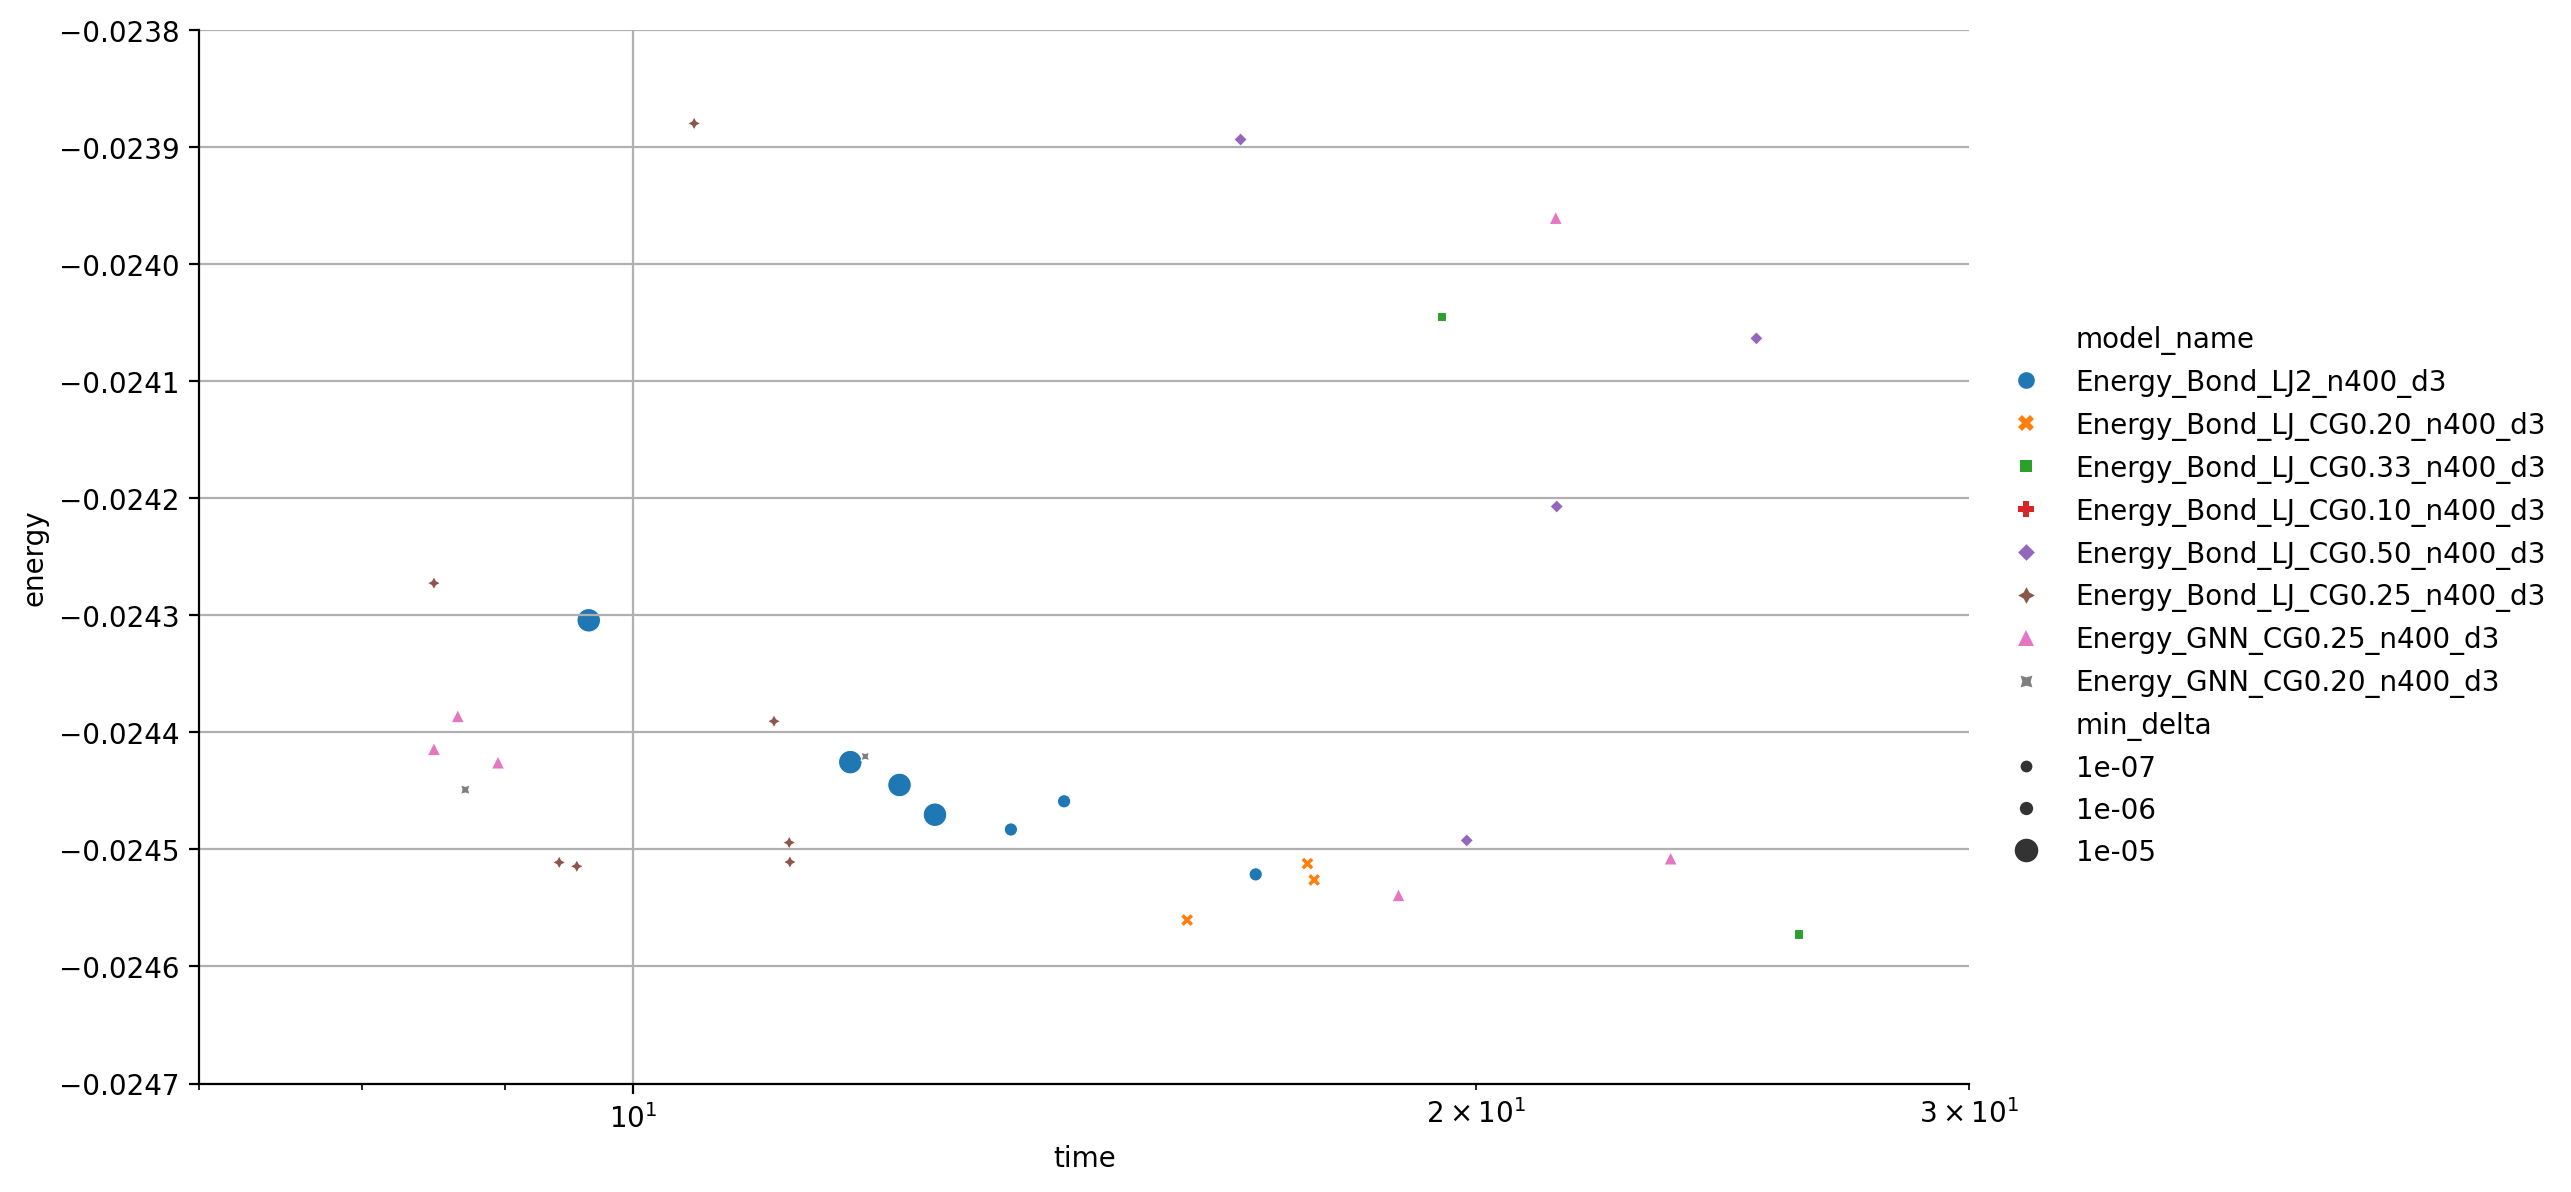

In [227]:
# plot the filtered dataframe using sns directly on df
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='min_delta', height=6, aspect=1.7)

plt.ylim(-.0247, -.0238)
plt.xlim(7,30)
plt.xscale('log')
plt.grid()

In [222]:
# print shape and name of parameters
for name, param in gnn_reparam.named_parameters():
    print(name, param.shape)
    
# print total number of parameters
sum(p.numel() for p in gnn_reparam.parameters())

latent_embedding torch.Size([400, 10])
gnn.layers.0.weight torch.Size([10, 5])
gnn.layers.0.bias torch.Size([5])
gnn.layers.0.self_loops torch.Size([10, 5])
gnn.layers.1.weight torch.Size([3, 5])
gnn.layers.1.bias torch.Size([3])


4123

In [51]:
energy_bond_lj.get_indices()

In [52]:
# cg_em.early_stopping_triggered = False
h = gnn_em.train(20000)

Early stopping at step 6760


In [53]:
len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}"

(339, '-0.0241, 8.22')

Text(0.5, 1.0, 'Energy vs time (min E: -0.0245, t=8.31 s)')

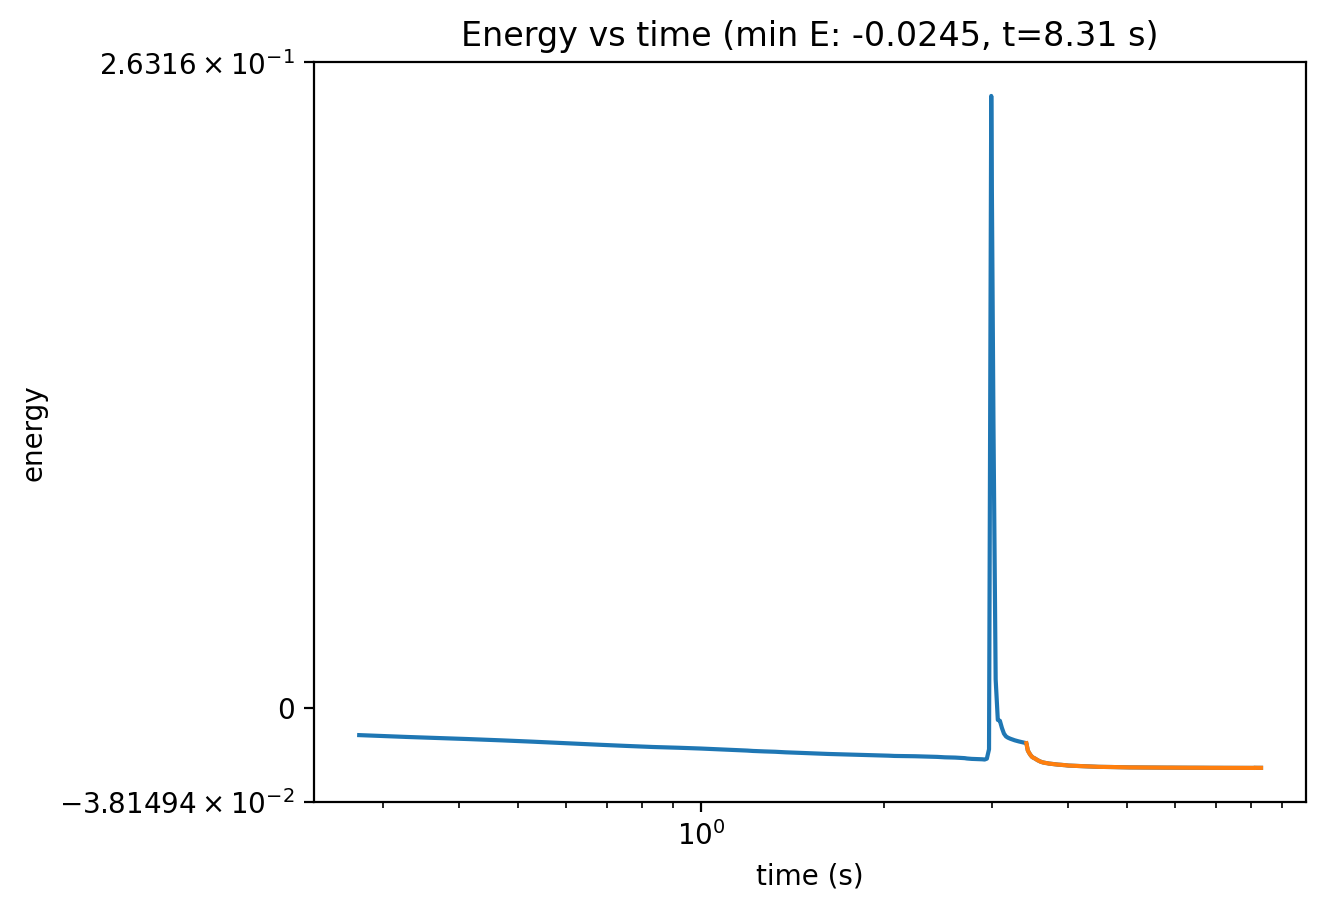

In [200]:
gnn_em.plot_history(start=10)
gnn_em.plot_history(start=gnn_em.gnn_steps)
h = gnn_em.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
# plt.yscale('linear')


In [57]:
from coarsegrainer.plotting import plot_graph_3D,plot_line_3D

In [213]:
r = 1e-1
# v = plot_graph_3D(V(cg_em.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
# v = plot_line_3D(V(gnn_em.get_x()), A, r = r, eps=1e-4, colormap='jet')
v = plot_line_3D(V(gnn_em.gnn()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [59]:
gnn_em.start_fine_graining()

In [60]:
gnn_em.min_delta

1e-06

In [61]:
# cg_em.min_delta = 1e-6
gnn_em.min_delta, gnn_em.patience, gnn_em.fine_grained, gnn_em.early_stopping_triggered

(1e-06, 20, True, False)

In [62]:
gnn_em.optimizer.param_groups[0]['params'][0].shape

torch.Size([400, 3])

In [63]:
# cg_em.min_delta = 1e-6
# cg_em.early_stopping_triggered = False
h = gnn_em.train(20000)

Early stopping at step 9740


In [64]:
len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}"

(827, '-0.0245, 17.49')

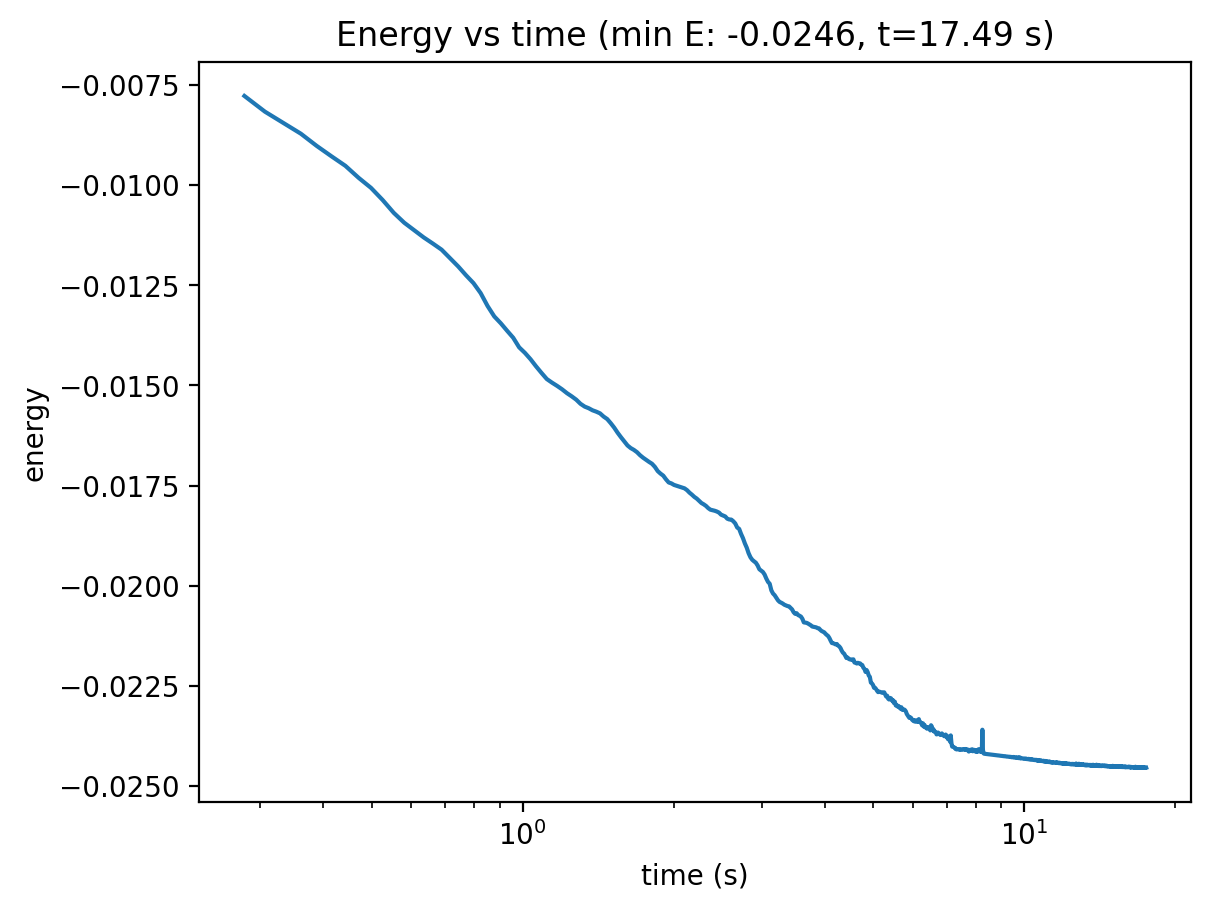

In [65]:
gnn_em.plot_history(start=10)
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')
# plt.xscale('linear')
plt.yscale('linear')


In [66]:
total_time = np.sum(h['time']) + cg_time
total_time

17.676391124725342

In [214]:
r = 5e-1
# v = plot_graph_3D(V(cg_em.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(gnn_em.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## LJ only

In [57]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2
# instantiate the EnergyMinimizerPytorch class
em = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=1., log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: LJ_loop
Logging to: ../results/logs/LJ_loop_n400_d3


In [58]:
exp_logger.run_experiment(em, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment LJ_loop_n400_d3
250 -0.0836, 3.84
500 -0.0851, 7.48
Early stopping at step 340
518 -0.085, 7.73


Text(0.5, 1.0, 'Energy vs time (min E: -0.0851, t=7.73 s)')

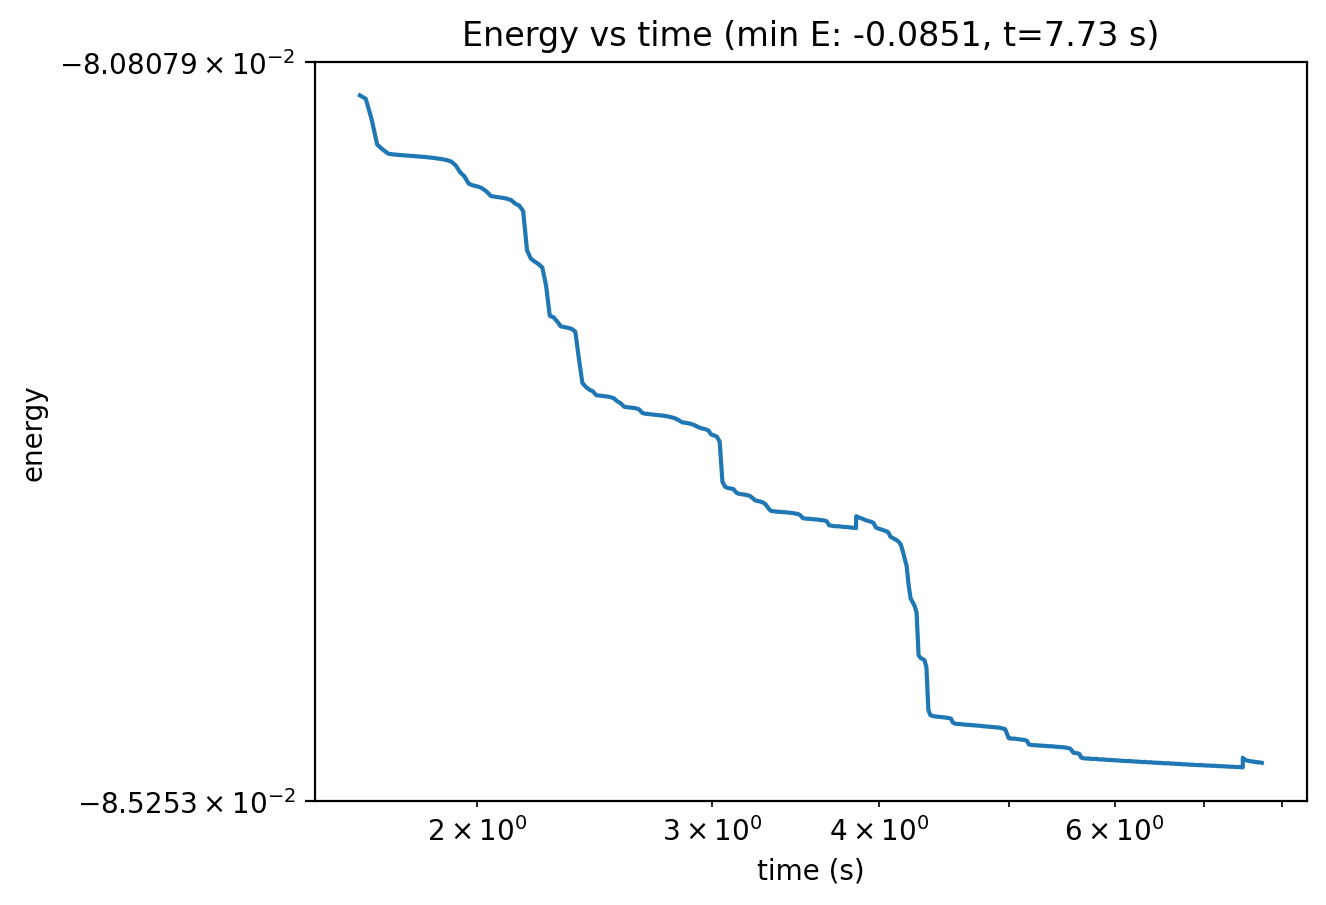

In [59]:
em.plot_history(start=100)
h = em.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [60]:
exp_logger.df

energy_function       model_name    energy       time    lr  clamp_grads  \
0  Energy_LJ_2scale  LJ_loop_n400_d3 -0.088609   7.755274  0.02          1.0   
1  Energy_LJ_2scale  LJ_loop_n400_d3 -0.002996   3.882936  0.02          1.0   
2  Energy_LJ_2scale  LJ_loop_n400_d3 -0.030882   4.033187  0.02          1.0   
3  Energy_LJ_2scale  LJ_loop_n400_d3 -0.091265   4.120032  0.02          1.0   
4  Energy_LJ_2scale  LJ_loop_n400_d3 -0.018082   3.479810  0.10          1.0   
5  Energy_LJ_2scale  LJ_loop_n400_d3 -0.097731  36.547231  0.01          1.0   
6  Energy_LJ_2scale  LJ_loop_n400_d3 -0.087591   7.848730  0.01          1.0   
7  Energy_LJ_2scale  LJ_loop_n400_d3 -0.085024   7.732135  0.01          1.0   

   patience  min_delta     x0_std  
0        20   0.000001   1.833794  
1        20   0.000001  14.806775  
2        20   0.000001   3.536488  
3        20   0.000001   1.800757  
4       200   0.000001   1.853205  
5       200   0.000001   1.784319  
6        20   0.000001   1.908398  
7        20   0.000001   1.832250

In [254]:
em.early_stopping_triggered = False
h = em.train(20000)

Early stopping


In [255]:
len(h['energy'])

412

Text(0.5, 1.0, 'Energy vs time (min E: -0.0436)')

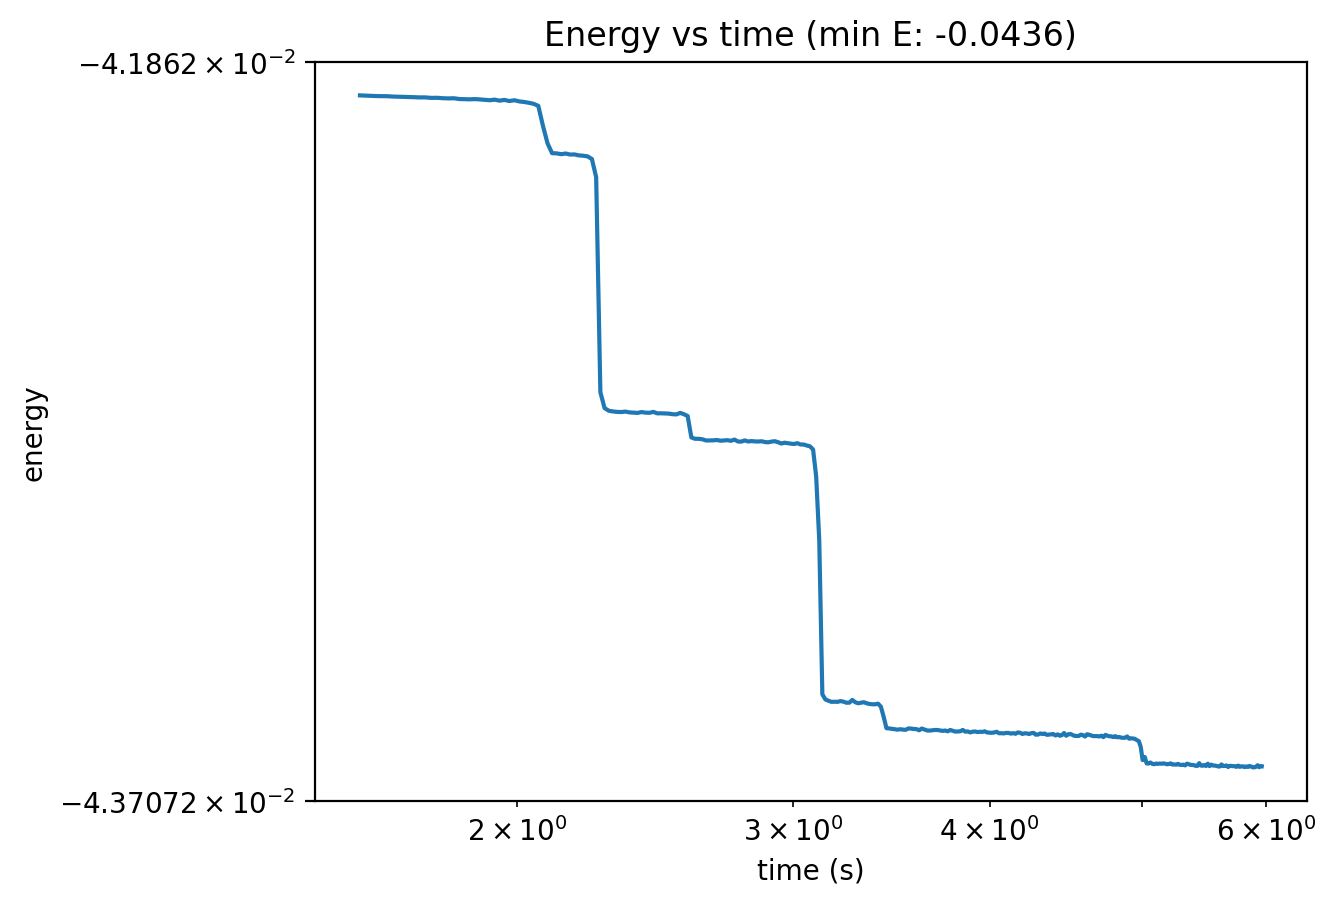

In [256]:
em.plot_history(start=100)
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g})')

In [251]:
em.history['time'][-1]

5.953773498535156

In [252]:
em.get_x().std(), init_sigma

(tensor(25.9991, device='cuda:0', grad_fn=<StdBackward0>), 2.9240177382128656)

In [61]:
r = 5e-1
# v = plot_graph_3D(V(em.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(em.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### CG Using multiple samples

In [170]:
init_sigma

3.6840314986403864

In [ ]:
energy_bond_lj.num_neg_pairs = n**2//2
energy_bond_lj.get_indices()
energy_bond_lj.indices_neg[0].shape

torch.Size([20000])

In [138]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 40
# produce k samples with different std for x
x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-2, 2e-1, k)[:, None, None].to(device)
cg_lj_sparse = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_lj_sparse.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.28 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.2917213439941406

In [139]:
init_sigma/16, 1/(2*d)

(0.23025196866502415, 0.16666666666666666)

In [140]:
A.shape, x.shape

(torch.Size([400, 400]), torch.Size([400, 3]))

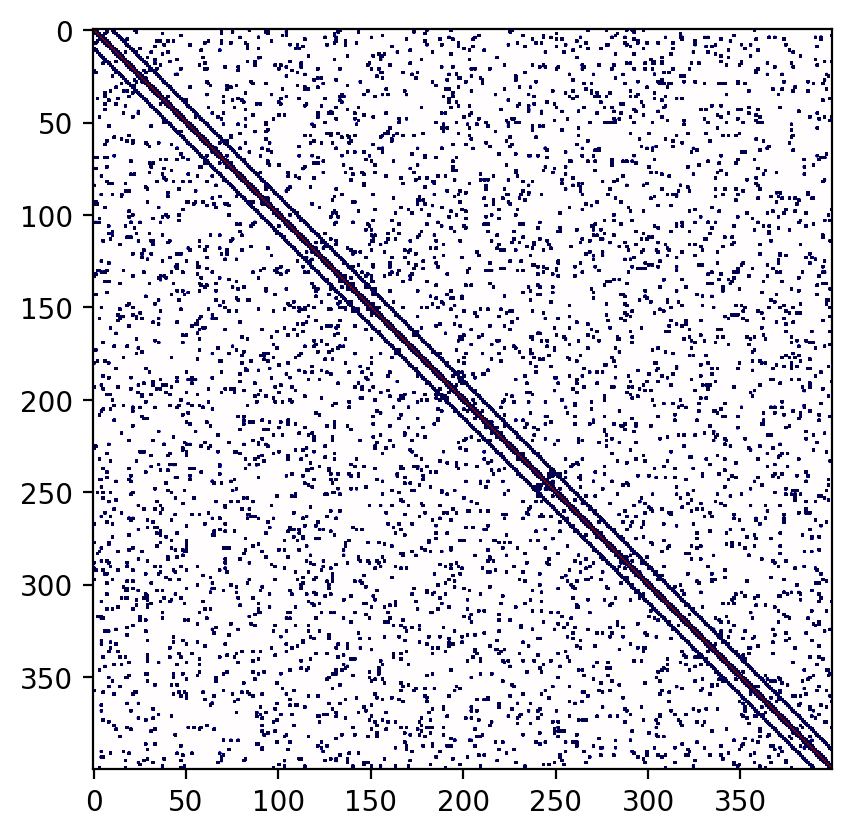

In [141]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_lj_sparse.L)), cmap='seismic', vmin=-b, vmax=b)


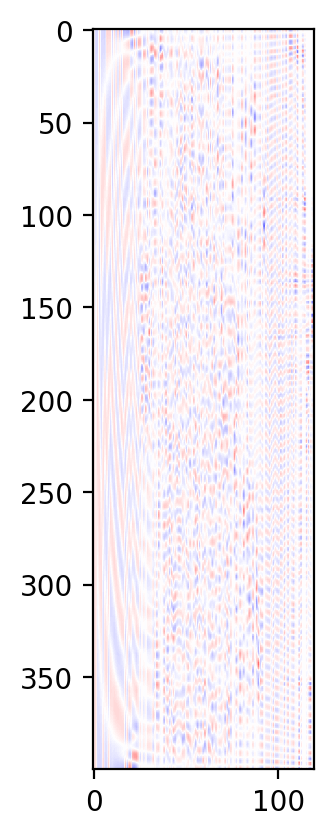

In [142]:
c = V(cg_lj_sparse.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [143]:
init_sigma

3.6840314986403864

In [157]:
num_cg_modes = n//3
initial_pos = x = init_sigma*torch.randn(n, d).to(device) /1
# instantiate the CGMinimizerPytorch class
cg_em = CGMinimizerPytorch(energy_lj, initial_pos, cg_lj_sparse.cg_modes[:,:num_cg_modes], 
            optimizer_type='Adam', lr=LR, lr_cg=2e-1,
            clamp_grads=1., log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name='CG_LJ_loop', 
            patience=PATIENCE, min_delta=MIN_DELTA,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*10)


Using Adam optimizer
Log name: CG_LJ_loop
Logging to: ../results/logs/CG_LJ_loop_n400_d3
Using Adam optimizer


In [158]:
exp_logger.run_experiment(cg_em, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment CG_LJ_loop_n400_d3


250 -0.067, 3.98
500 -0.096, 7.80
Early stopping at step 4520
Starting fine-graining
977 -0.127, 14.91
1227 -0.13, 18.59
Early stopping at step 240
1240 -0.13, 18.77


In [159]:
# remove the last experiment
# exp_logger.results = exp_logger.results[:-1]

In [160]:
exp_logger.df

energy_function          model_name    energy       time    lr  \
0  Energy_LJ_2scale     LJ_loop_n400_d3 -0.088609   7.755274  0.02   
1  Energy_LJ_2scale     LJ_loop_n400_d3 -0.002996   3.882936  0.02   
2  Energy_LJ_2scale     LJ_loop_n400_d3 -0.030882   4.033187  0.02   
3  Energy_LJ_2scale     LJ_loop_n400_d3 -0.091265   4.120032  0.02   
4  Energy_LJ_2scale     LJ_loop_n400_d3 -0.018082   3.479810  0.10   
5  Energy_LJ_2scale     LJ_loop_n400_d3 -0.097731  36.547231  0.01   
6  Energy_LJ_2scale     LJ_loop_n400_d3 -0.087591   7.848730  0.01   
7  Energy_LJ_2scale     LJ_loop_n400_d3 -0.085024   7.732135  0.01   
8  Energy_LJ_2scale  CG_LJ_loop_n400_d3 -0.130437  38.136391  0.01   
9  Energy_LJ_2scale  CG_LJ_loop_n400_d3 -0.129834  18.765692  0.02   

   clamp_grads  patience  min_delta     x0_std  
0          1.0        20   0.000001   1.833794  
1          1.0        20   0.000001  14.806775  
2          1.0        20   0.000001   3.536488  
3          1.0        20   0.000001   1.800757  
4          1.0       200   0.000001   1.853205  
5          1.0       200   0.000001   1.784319  
6          1.0        20   0.000001   1.908398  
7          1.0        20   0.000001   1.832250  
8          1.0        20   0.000001   1.817656  
9          1.0        20   0.000001   3.664319

Text(0.5, 1.0, 'Energy vs time (min E: -0.13, t=18.77 s)')

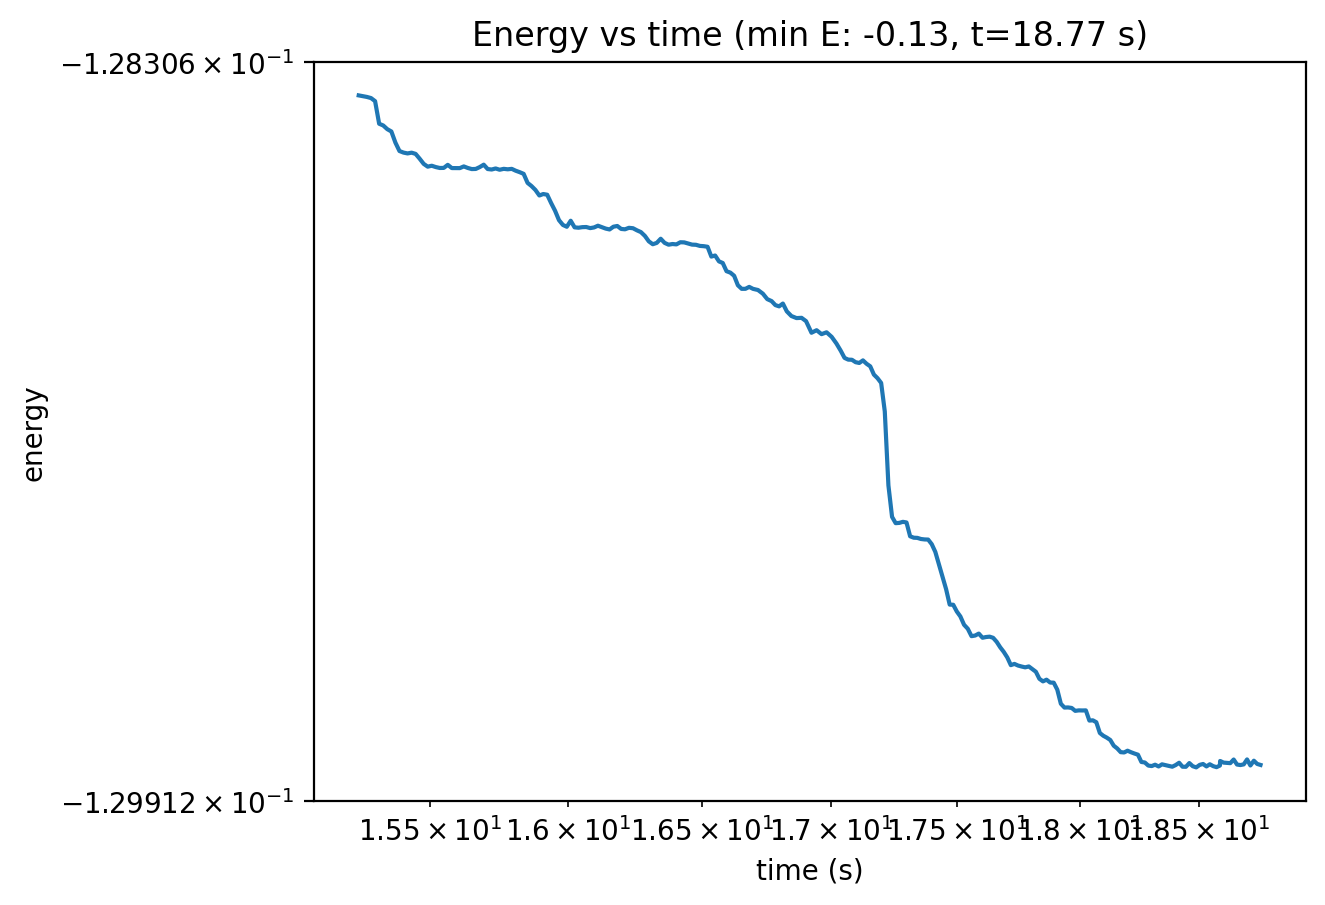

In [161]:
cg_em.plot_history(start=1000)
h = cg_em.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [162]:
r = 5e-1
# v = plot_graph_3D(V(cg_em.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_em.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [163]:
h = cg_lj_sparse.hessian(cg_em.get_x())

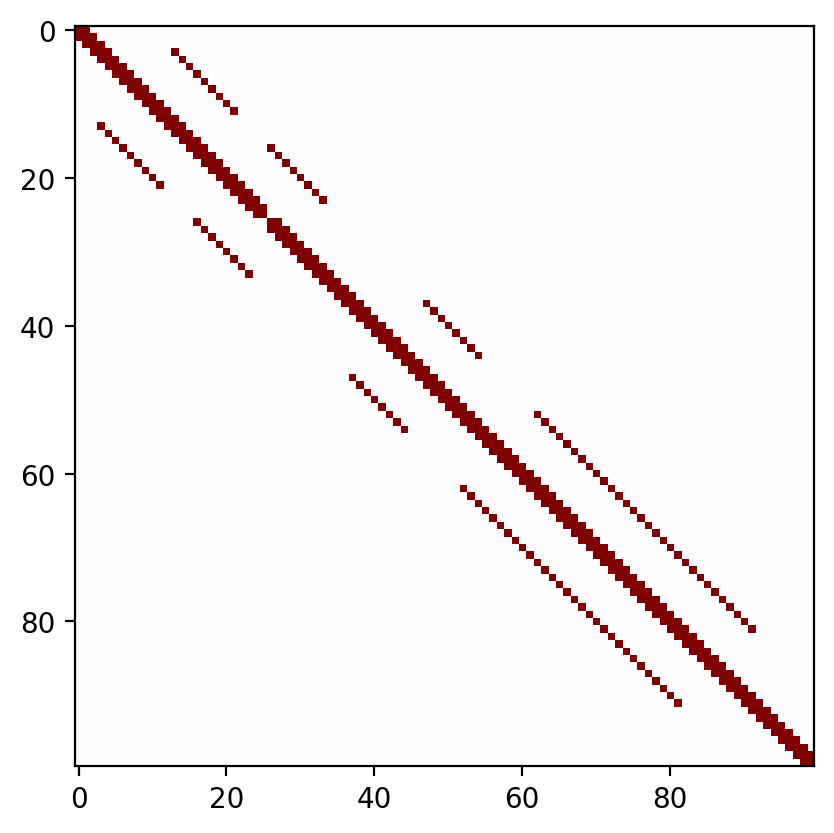

In [168]:
plt.imshow(np.arcsinh(1e3*V(h.norm(dim=(1,3))))[:100,:100], cmap='seismic', vmin=-1, vmax=1)


In [290]:
cg_em.start_fine_graining()

In [291]:
# cg_em.min_delta = 1e-6
cg_em.min_delta, cg_em.patience, cg_em.fine_grained, cg_em.early_stopping_triggered

(9.999999999999999e-06, 20, True, False)

In [292]:
cg_em.early_stopping_triggered = False
h = cg_em.train(20000)

Early stopping


In [293]:
len(h['energy'])

1027

Text(0.5, 1.0, 'Energy vs time (min E: 1.54e+05)')

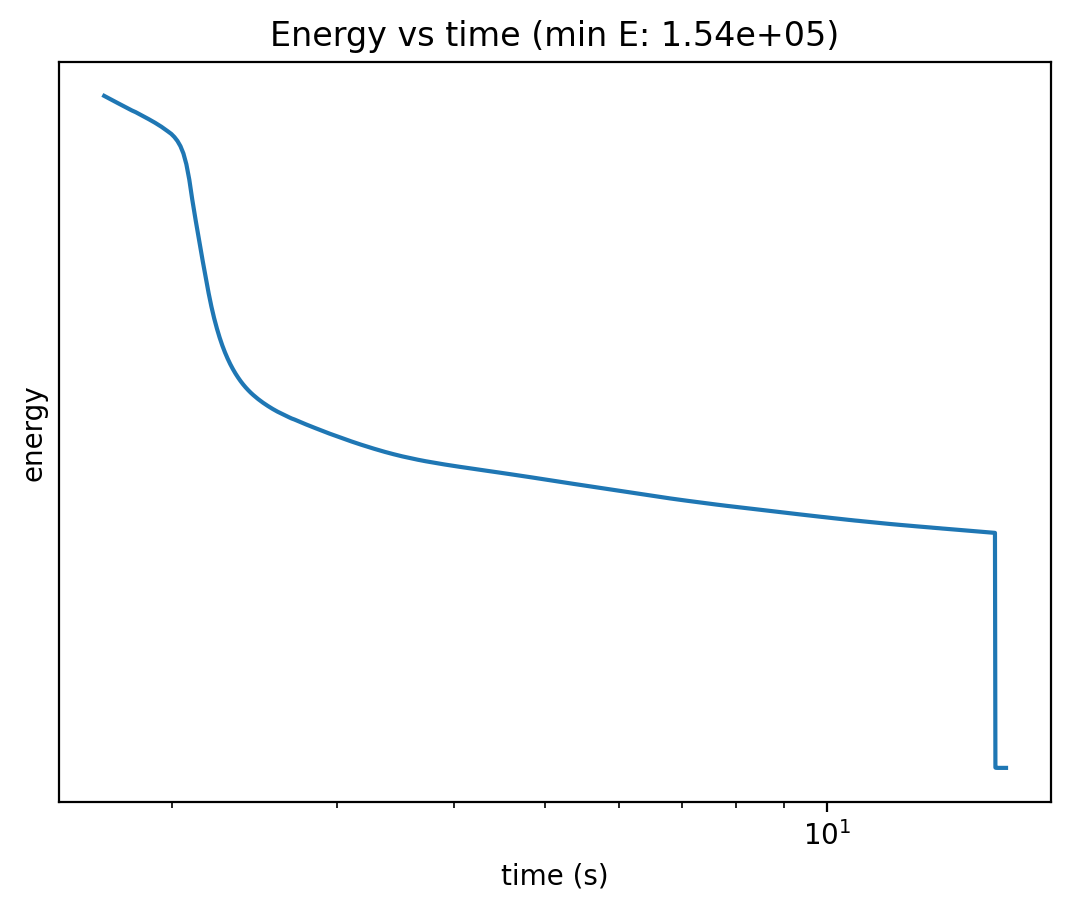

In [294]:
cg_em.plot_history(start=100)
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g})')


In [295]:
h['time'][-1]

15.532986402511597

In [ ]:
r = 5e-1
# v = plot_graph_3D(V(cg_em.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_em.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()